In [1]:
import os

def move_to_parent_dir():
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    os.chdir(parent_directory)
    print("Working directory:", os.getcwd())

move_to_parent_dir() 

Working directory: c:\Users\benjo\OneDrive\Data Science Masters\DSMP\dsmp-2024-group-19


In [2]:
from tools import get_Tapes
raw_tapes = get_Tapes(125,0)
tapes_data = [t["Price"].resample("1min").last().ffill().to_numpy() for t in raw_tapes] # resample down to 1 min

Opening UoB_Set01_2025-01-02tapes.csv
Opening UoB_Set01_2025-01-03tapes.csv
Opening UoB_Set01_2025-01-06tapes.csv
Opening UoB_Set01_2025-01-07tapes.csv
Opening UoB_Set01_2025-01-08tapes.csv
Opening UoB_Set01_2025-01-09tapes.csv
Opening UoB_Set01_2025-01-10tapes.csv
Opening UoB_Set01_2025-01-13tapes.csv
Opening UoB_Set01_2025-01-14tapes.csv
Opening UoB_Set01_2025-01-15tapes.csv
Opening UoB_Set01_2025-01-16tapes.csv
Opening UoB_Set01_2025-01-17tapes.csv
Opening UoB_Set01_2025-01-20tapes.csv
Opening UoB_Set01_2025-01-21tapes.csv
Opening UoB_Set01_2025-01-22tapes.csv
Opening UoB_Set01_2025-01-23tapes.csv
Opening UoB_Set01_2025-01-24tapes.csv
Opening UoB_Set01_2025-01-27tapes.csv
Opening UoB_Set01_2025-01-28tapes.csv
Opening UoB_Set01_2025-01-29tapes.csv
Opening UoB_Set01_2025-01-30tapes.csv
Opening UoB_Set01_2025-01-31tapes.csv
Opening UoB_Set01_2025-02-03tapes.csv
Opening UoB_Set01_2025-02-04tapes.csv
Opening UoB_Set01_2025-02-05tapes.csv
Opening UoB_Set01_2025-02-06tapes.csv
Opening UoB_

In [3]:
# get test data
import matplotlib.pyplot as plt
import numpy as np
from numba import njit


# define broker

def broker(actor, price_data: np.array, starting_cash: int):
    time_index = 0
    final_time_index = price_data.shape[0]
    num_stocks = np.zeros_like(price_data)
    cash_value = np.zeros_like(price_data)
    cash_value[0] = starting_cash

    while True:
        action = actor(price_data[:time_index], cash_value[time_index], num_stocks[time_index])

        while abs(action) > 0:
            if action > 0: # buy  stock
                if cash_value[time_index] >= price_data[time_index]:
                    cash_value[time_index] = cash_value[time_index] - price_data[time_index]
                    num_stocks[time_index] = num_stocks[time_index] + 1

                action += -1

            else: # sell one stock
                if num_stocks[time_index] > 0:
                    num_stocks[time_index] = num_stocks[time_index] - 1
                    cash_value[time_index] = cash_value[time_index] + price_data[time_index]

                action += 1

        time_index += 1
        if time_index >= final_time_index:
            break

        num_stocks[time_index] = num_stocks[time_index - 1]
        cash_value[time_index] = cash_value[time_index - 1]

    total_value = num_stocks * price_data + cash_value
    profit = (total_value[-1] / starting_cash) - 1
    
    return num_stocks, cash_value, total_value, profit

# generate folds
def generate_folds(tapes_data, n_folds=5):
    tapes_data = np.array(tapes_data)
    fold_size = len(tapes_data) // n_folds
    
    for i in range(n_folds):
        start_index = i * fold_size
        end_index = (i + 1) * fold_size if i < n_folds - 1 else len(tapes_data)
        
        test_indices = np.arange(start_index,end_index,1, dtype=int)
        # Test split
        test_data = tapes_data[test_indices]
        
        # Training split
        train_data = np.delete(tapes_data, test_indices, axis=0)
        
        yield train_data, test_data

def display_results(results, data):
    # Plotting Actor vs. Data
    plt.figure(figsize=(20, 6))
    plt.plot(results[2], color='red', label="Actor's Performance")
    plt.legend(loc='upper right')
    plt.twinx()
    plt.plot(data, color='blue', label="Market Data", alpha=0.7)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Actor Performance vs. Market Data")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Plotting Stocks Held and Cash Held
    plt.figure(figsize=(20, 6))
    plt.plot(results[0], color='orange', label="Stocks Held")
    plt.legend(loc='upper right')
    plt.twinx()
    plt.plot(results[1], color='green', label="Cash Held")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.title("Portfolio Holdings Over Time")
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Example

In [4]:
cash = 10_000

@njit
def random_actor(current_data, current_cash, current_stocks):
    return np.random.randint(-10,11)


results = broker(random_actor, tapes_data[100], cash)
results[-1]

-0.07430000000000003

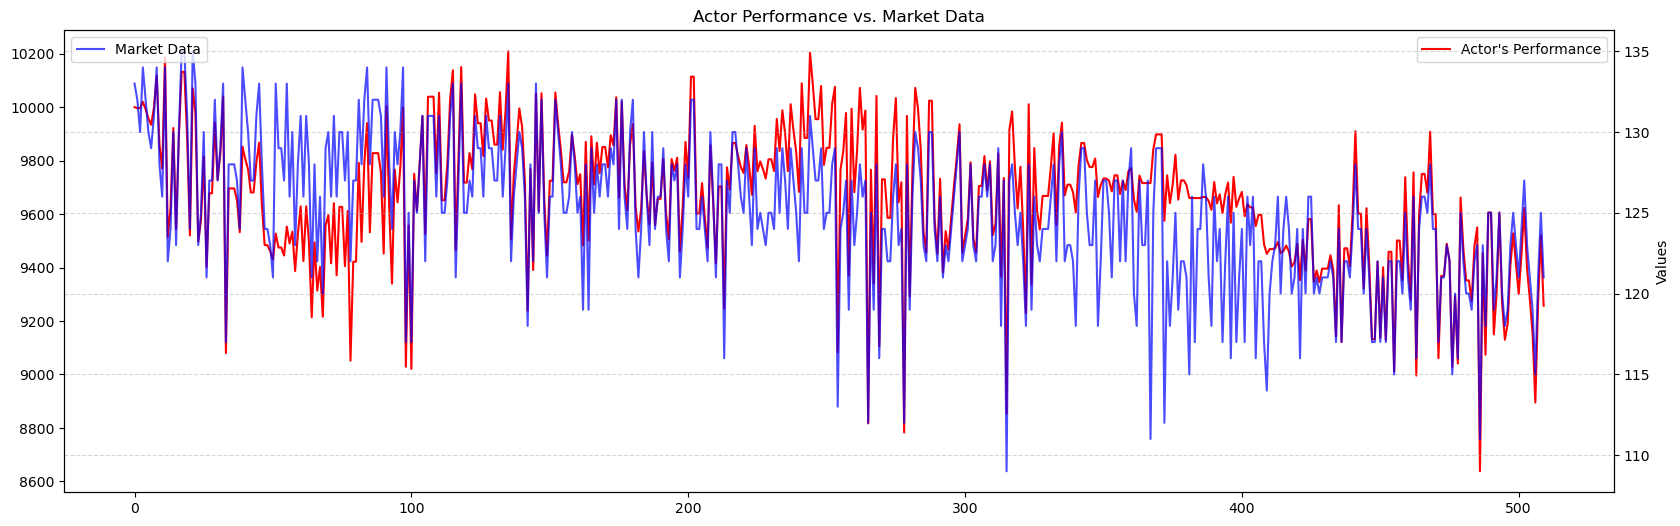

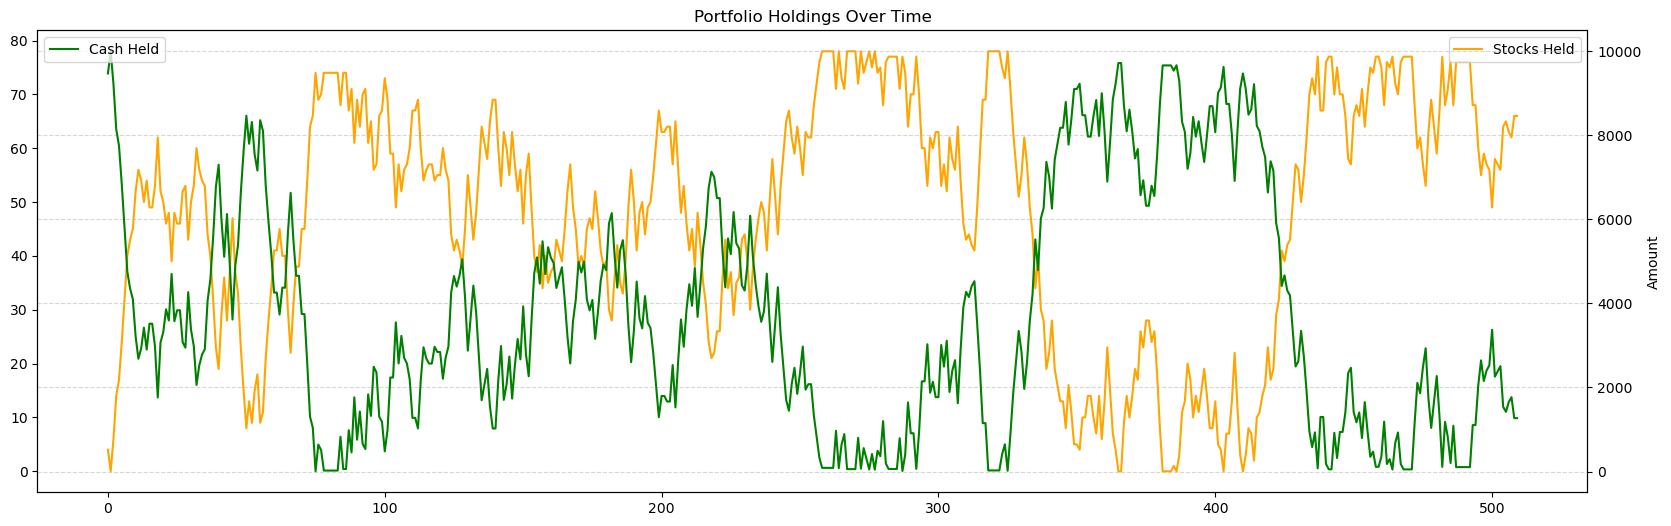

In [5]:
display_results(results, tapes_data[100])

# MA investigation

In [6]:
def MA_actor(current_data, current_cash, current_stocks):
    if len(current_data) == 0:
        return 0

    window = 2
    ma = np.mean(current_data[-window:])

    return int(current_data[-1] - ma)

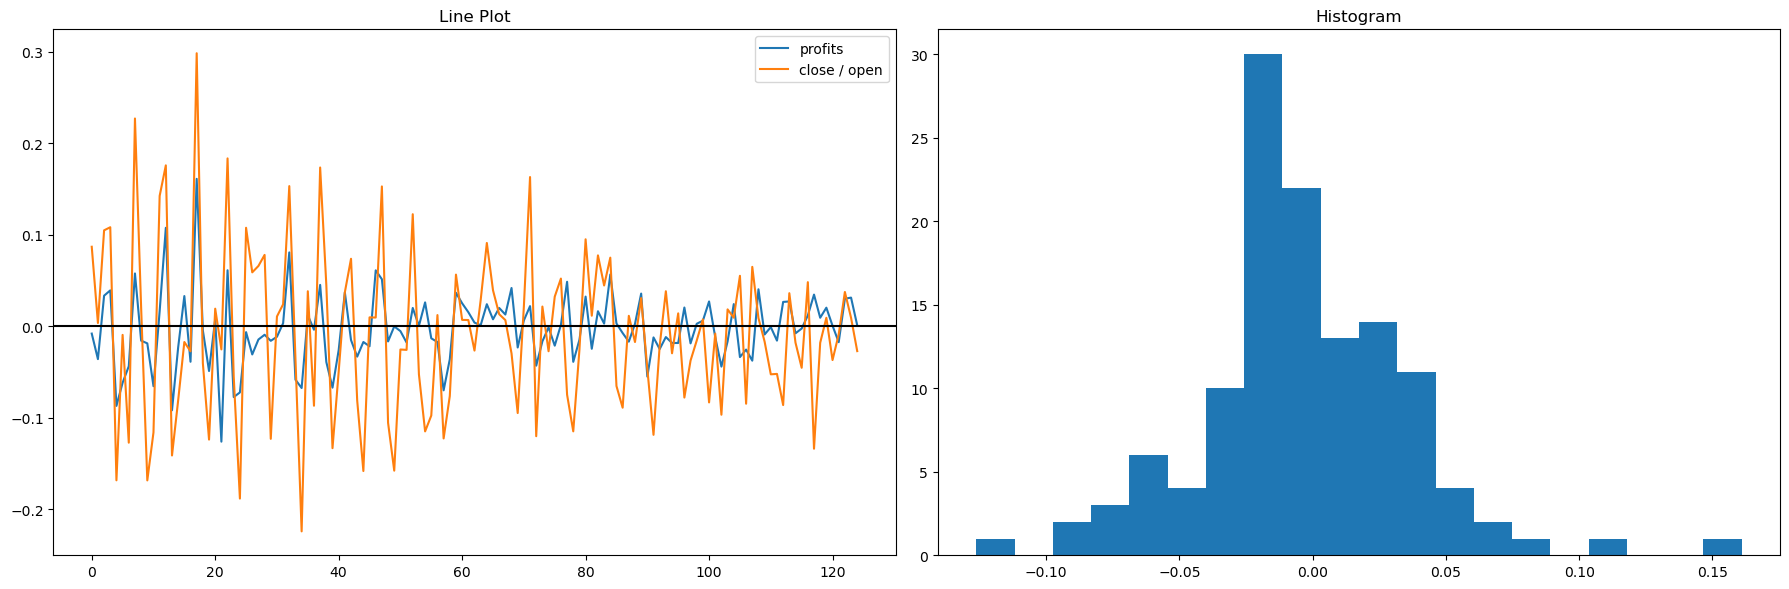

0.004303884847979254


In [7]:
profits = []
open_vs_close = []

for data in tapes_data:
    results = broker(MA_actor, data, cash)
    profits.append(results[-1])
    open_vs_close.append(data[-1] / data[1] - 1)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot line plot on the first subplot
axs[0].plot(profits, label = "profits")
axs[0].plot(open_vs_close, label = "close / open")
axs[0].set_title('Line Plot')
axs[0].axhline(0, color = "black")
axs[0].legend()

# Plot histogram on the second subplot
axs[1].hist(profits, bins=20)  # You can adjust the number of bins as needed
axs[1].set_title('Histogram')

# Show the plot
plt.tight_layout()
plt.show()

print(np.mean(np.array(profits) - np.array(open_vs_close)))

[176.50728066   0.77977534  -0.70054618  16.35092968]
Test Day 1


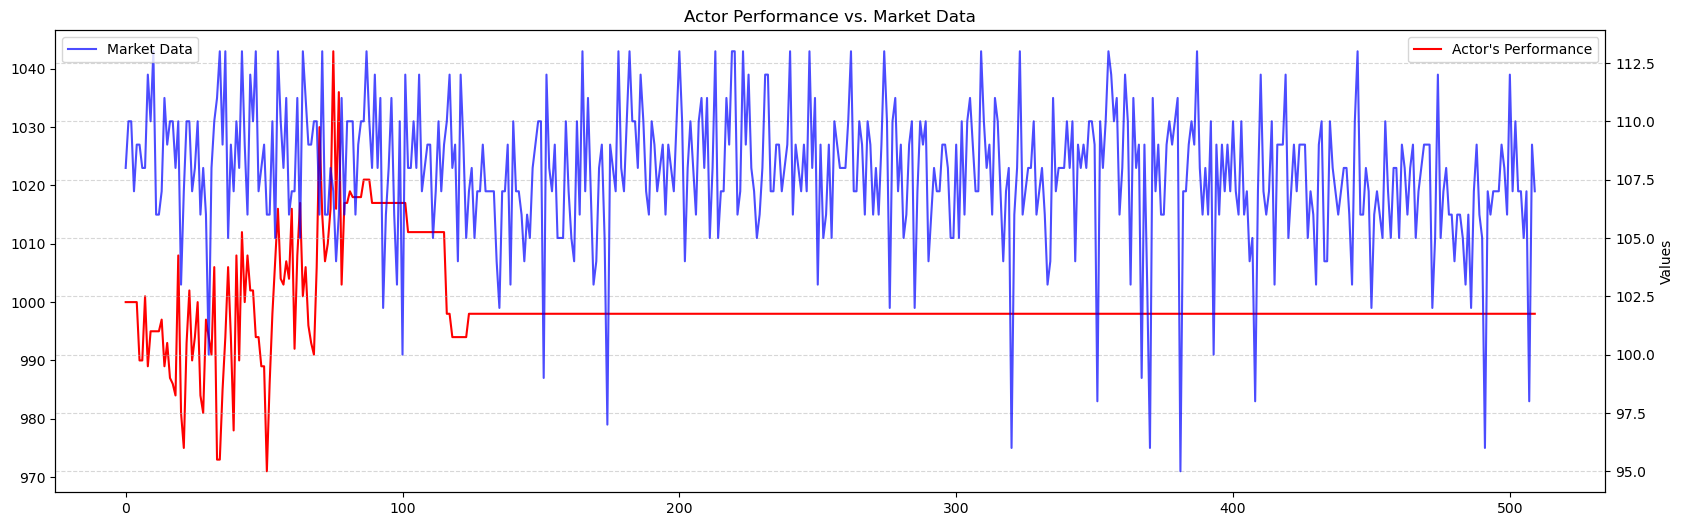

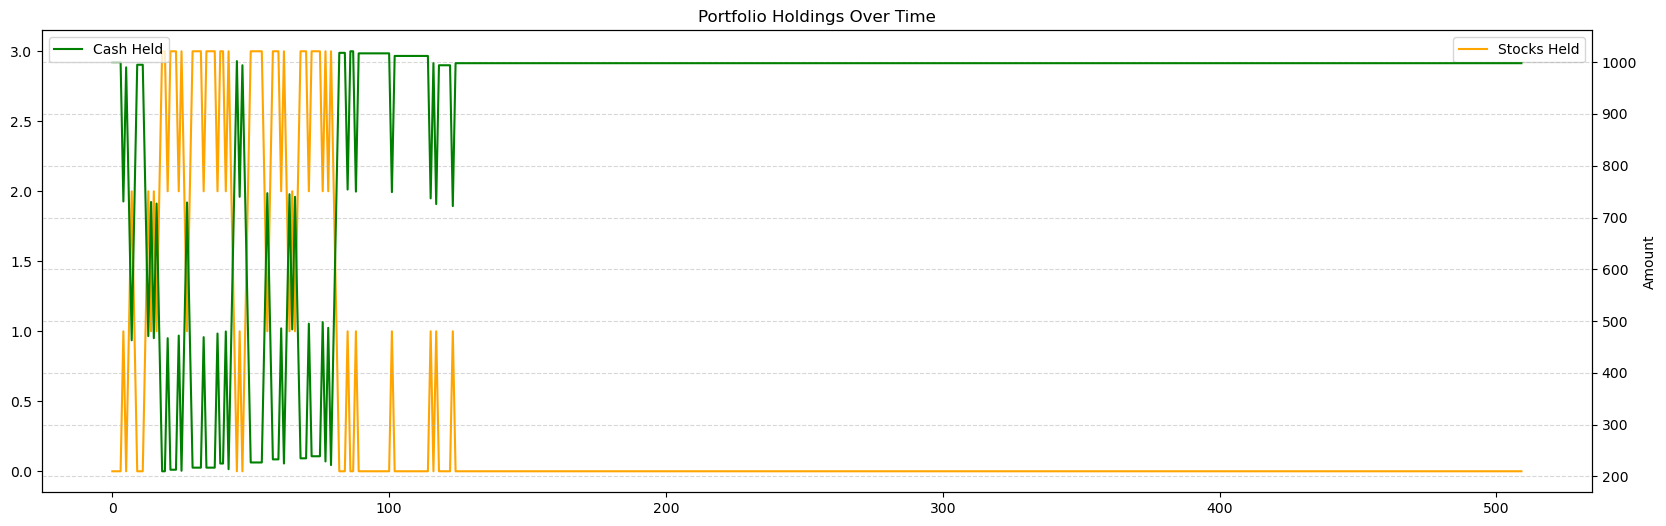

Test Day 13


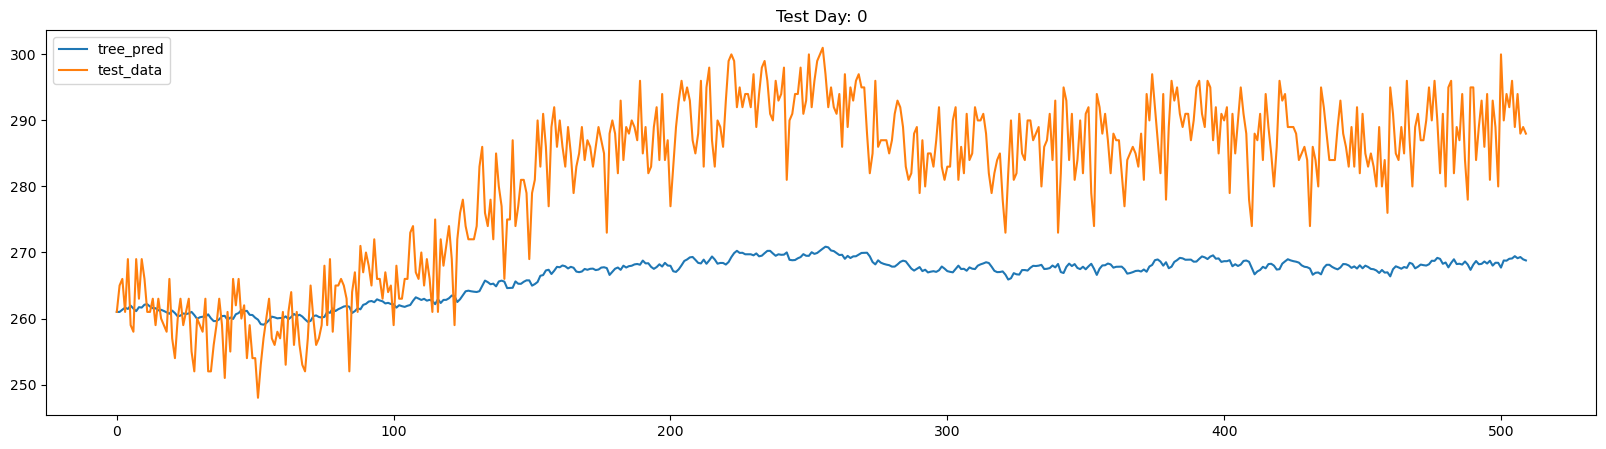

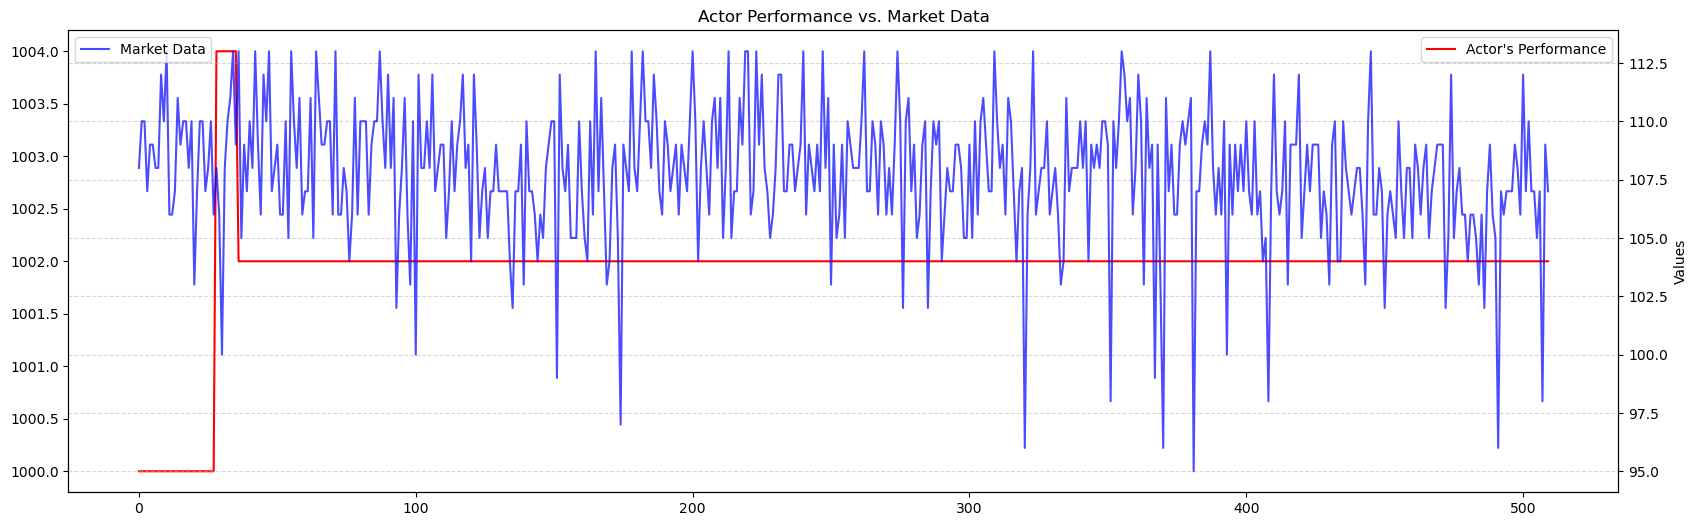

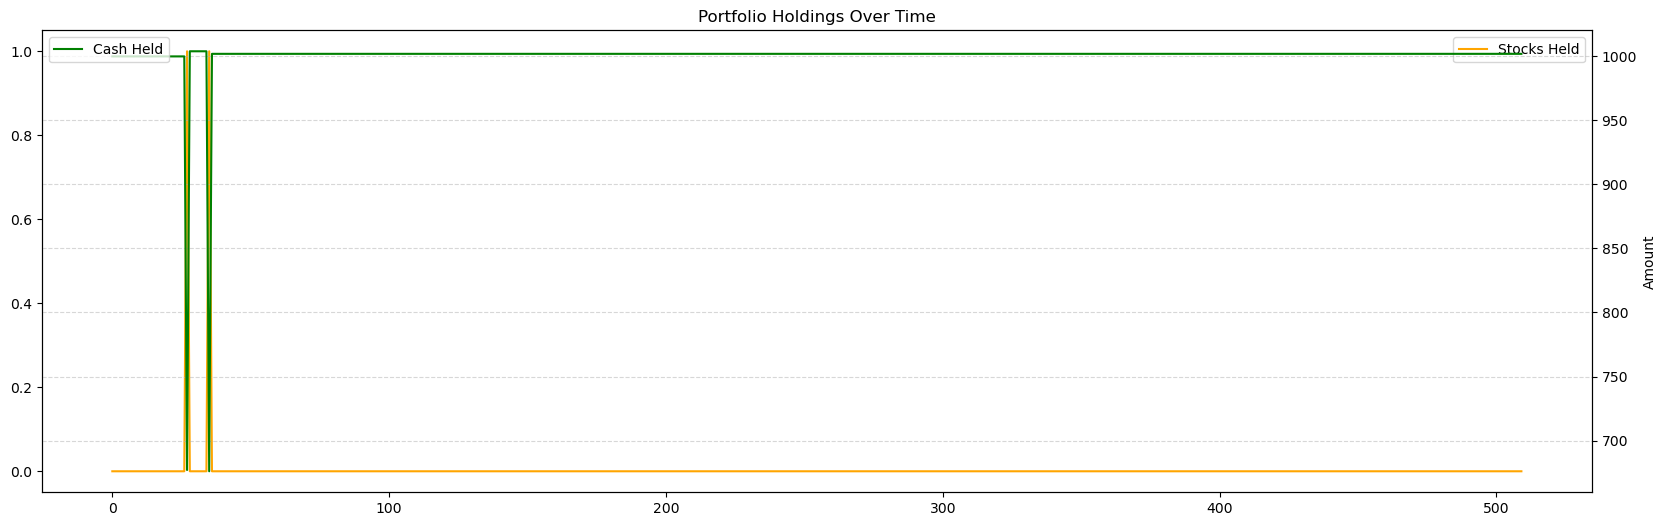

Test Day 25


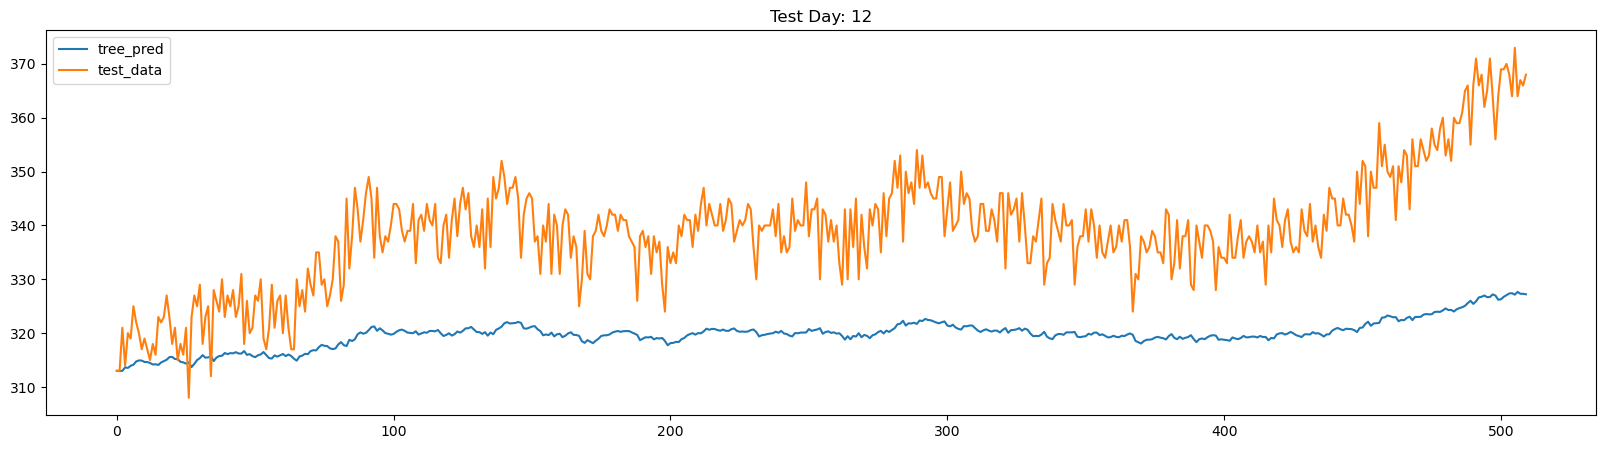

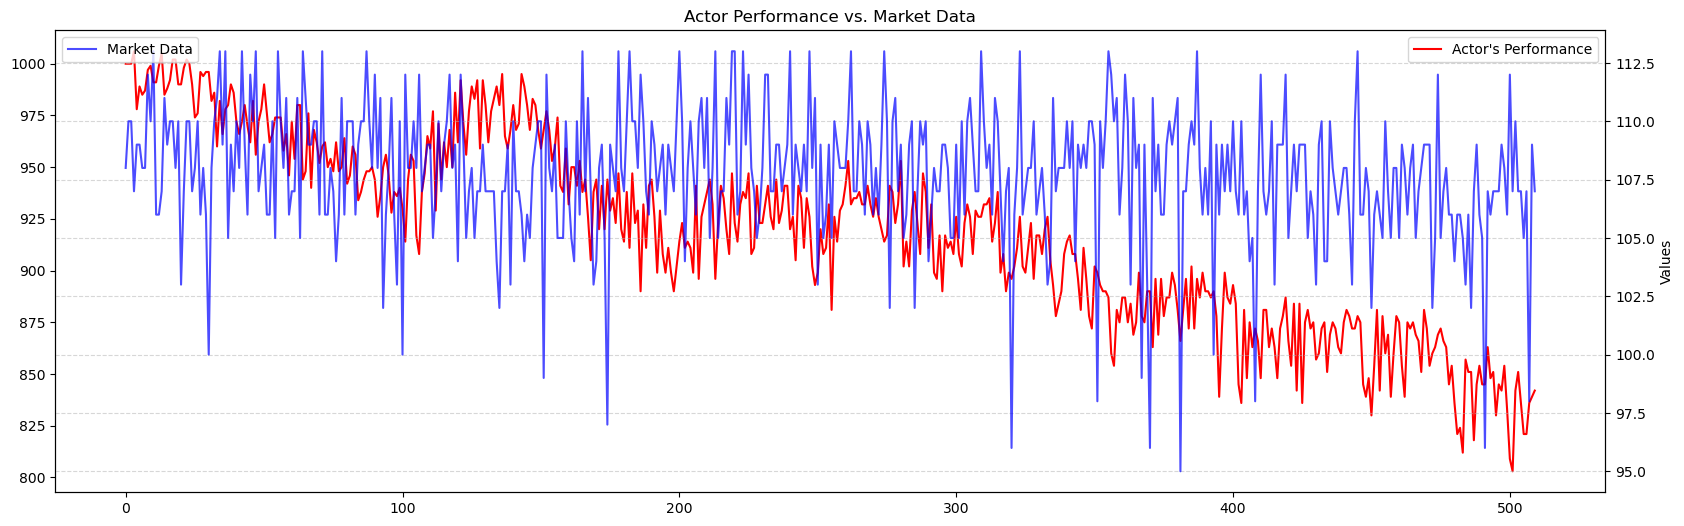

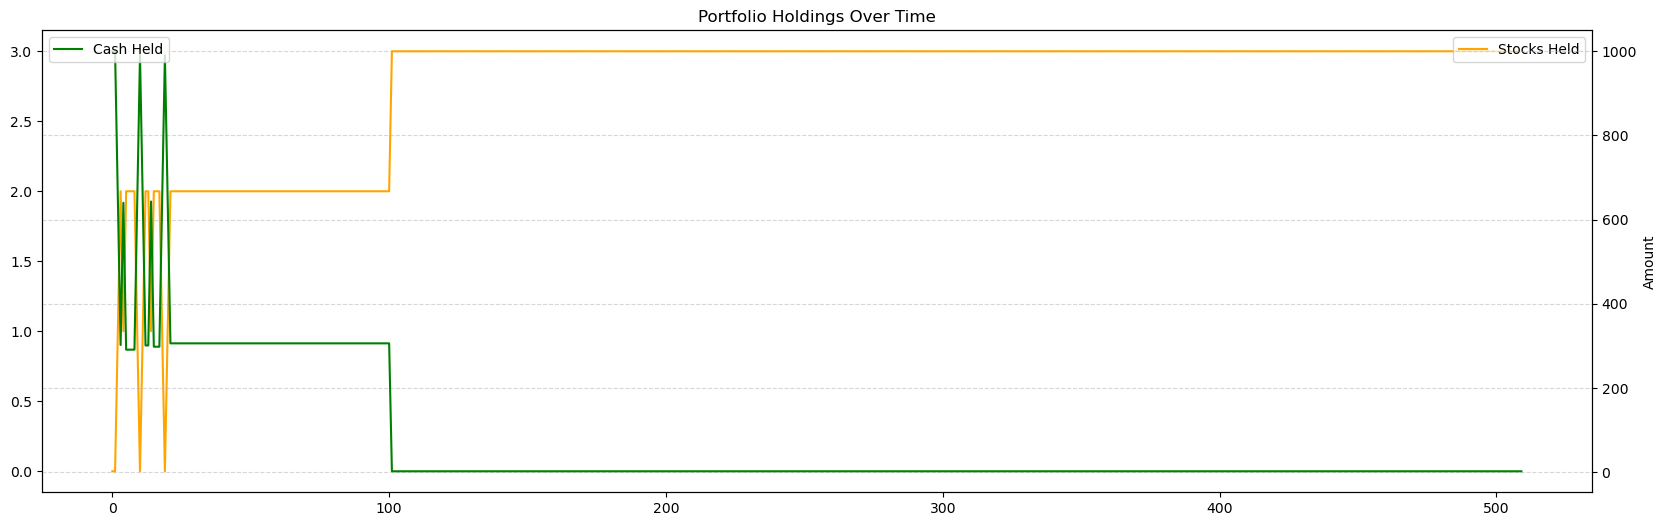

[188.07774154   0.78066448  -0.68823842  17.14921445]
Test Day 1


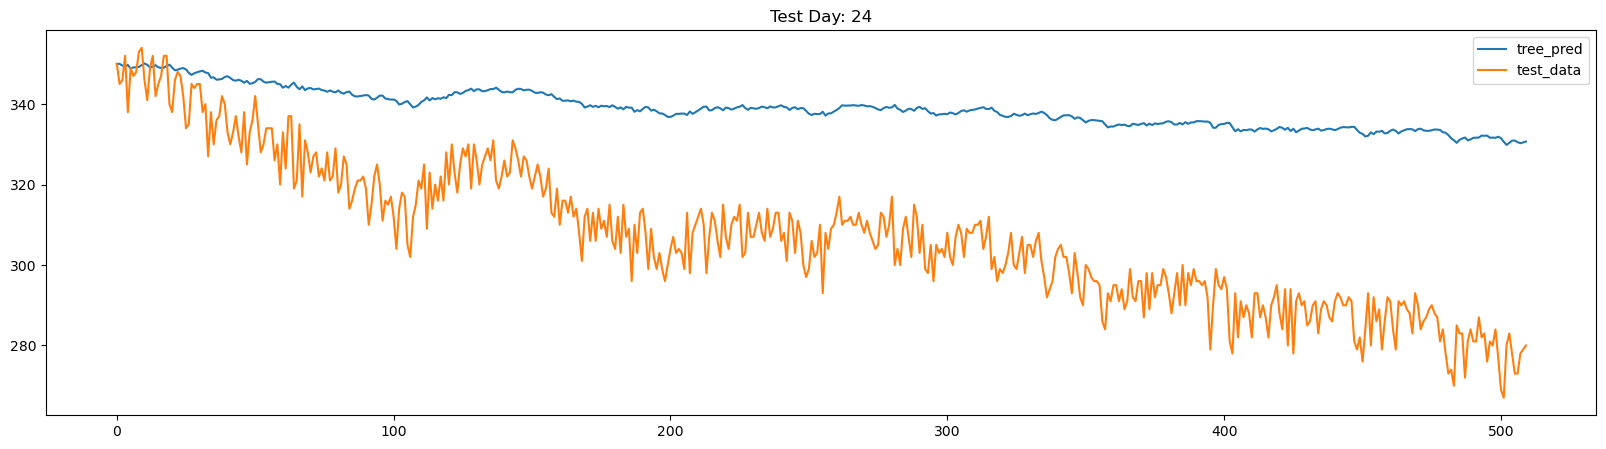

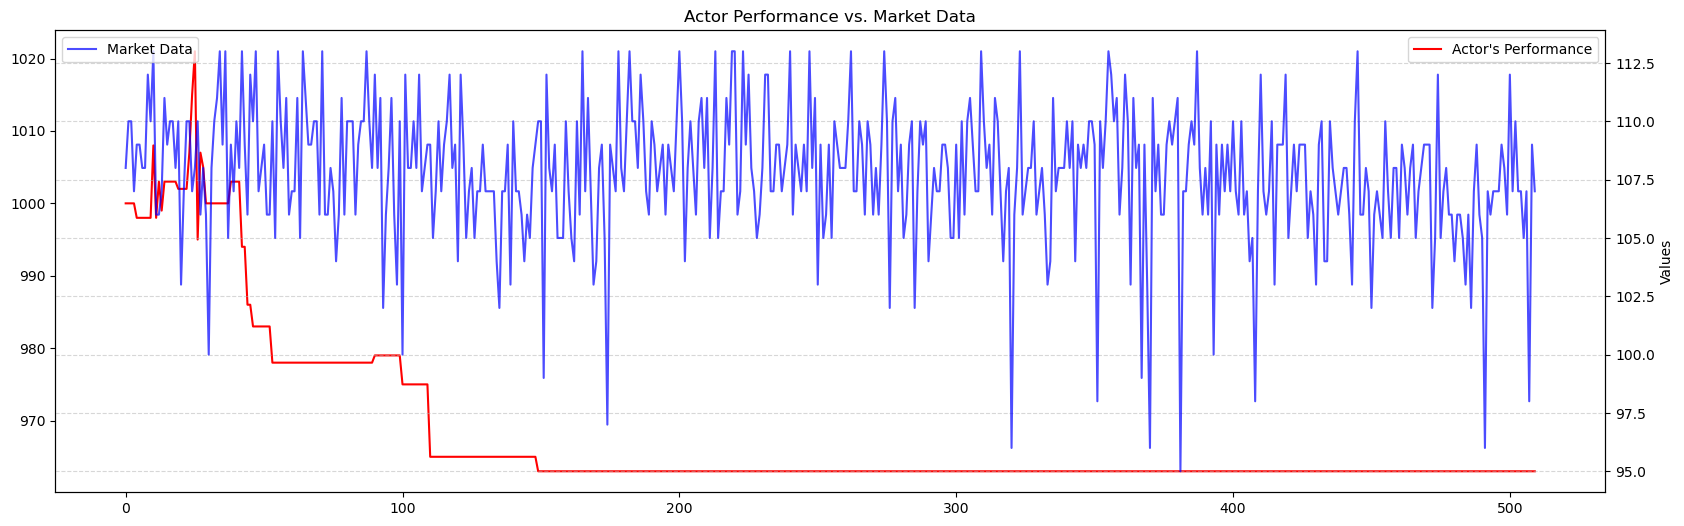

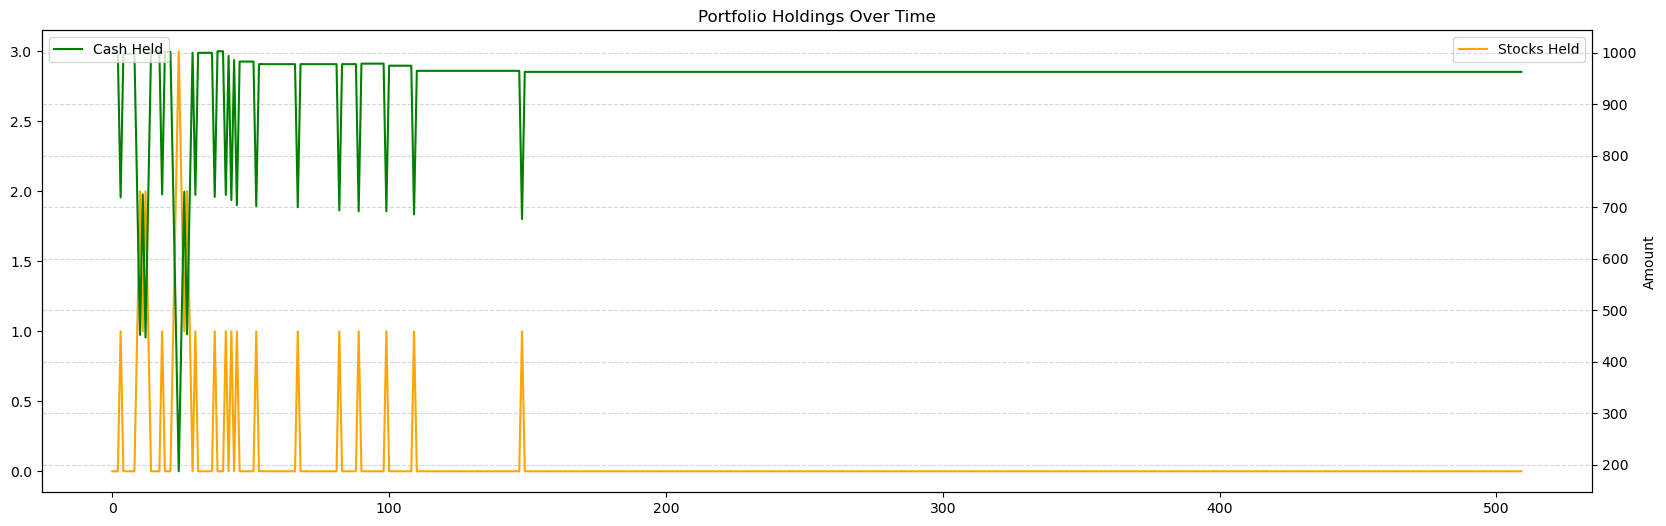

Test Day 13


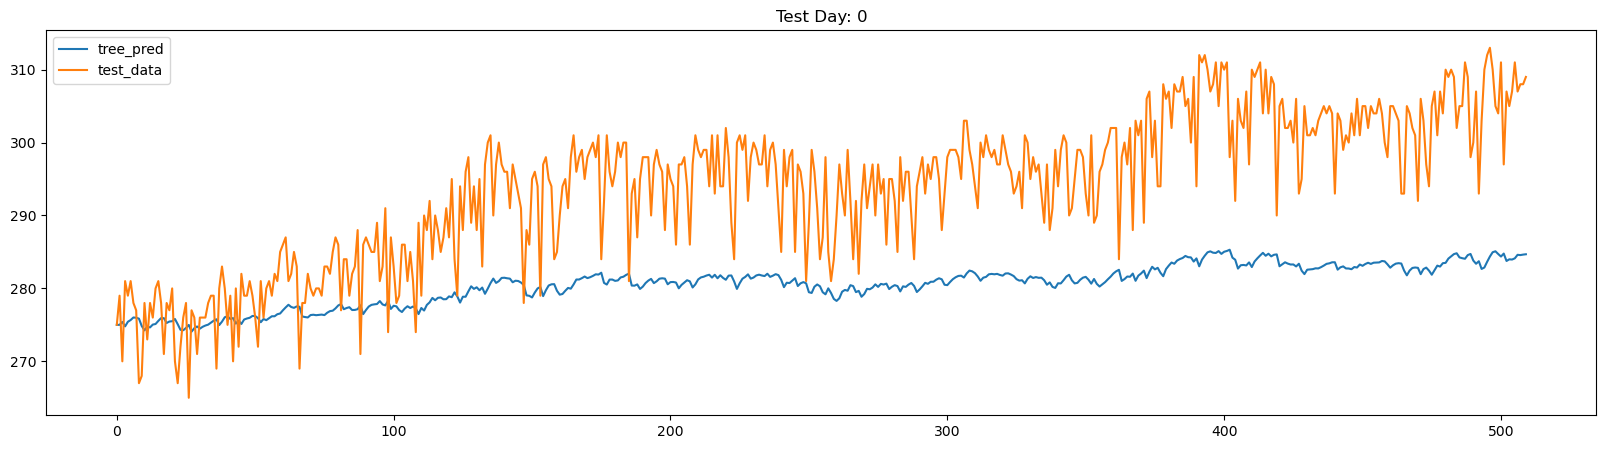

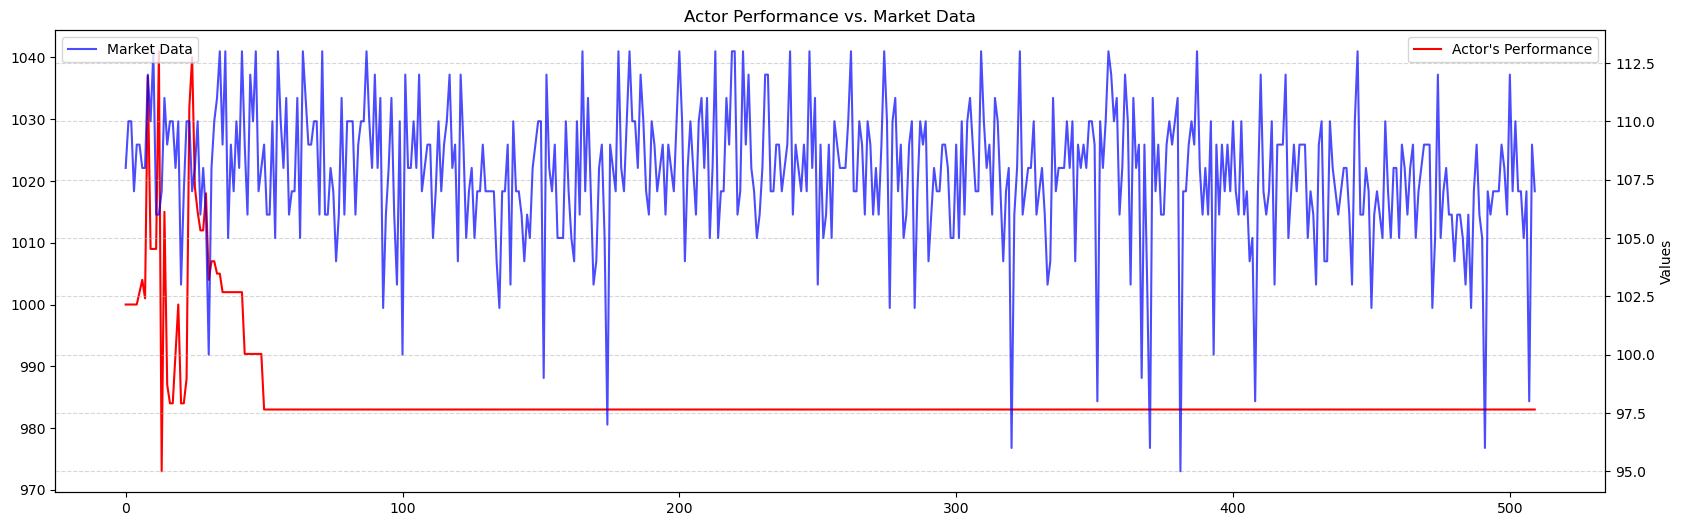

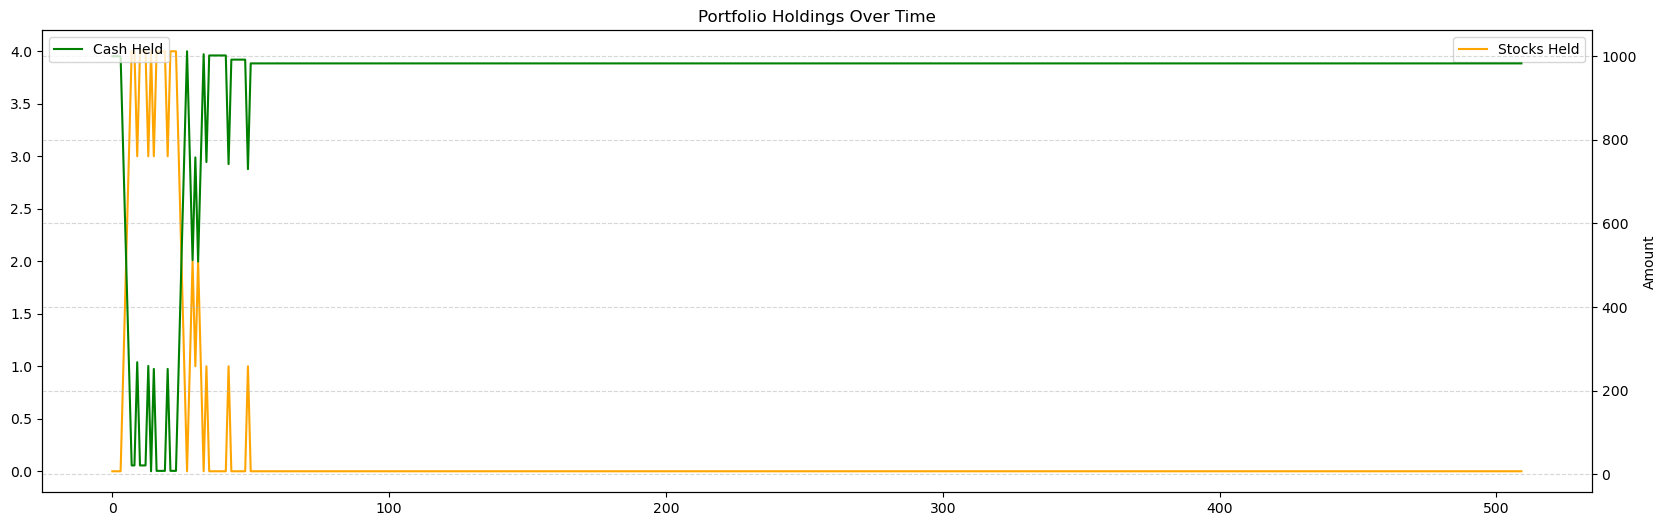

Test Day 25


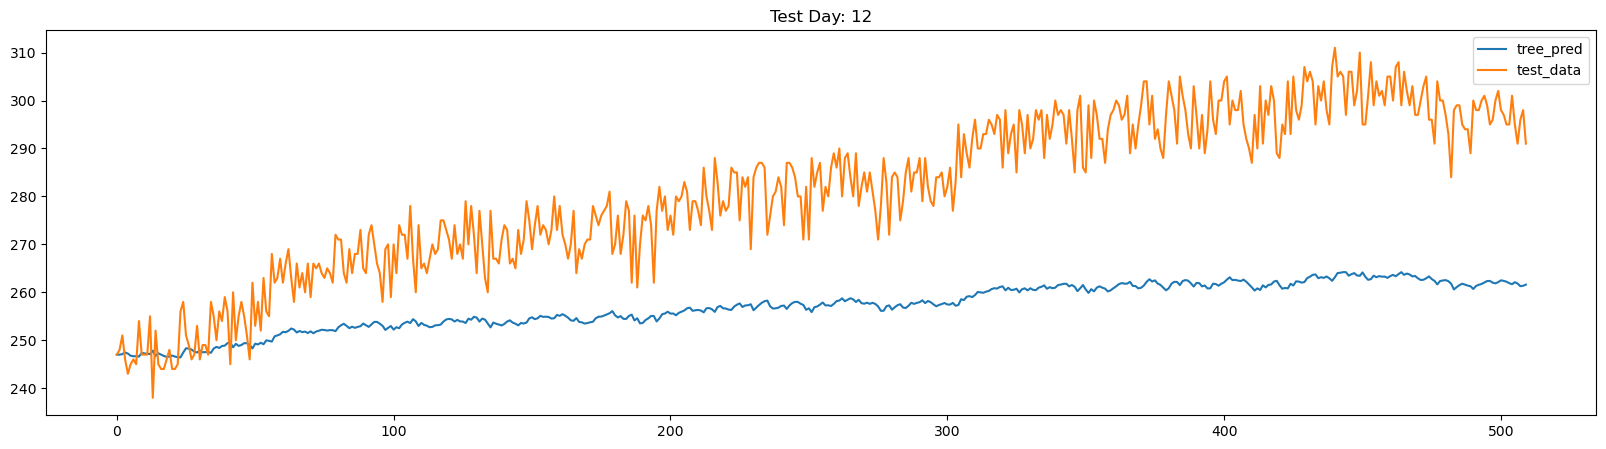

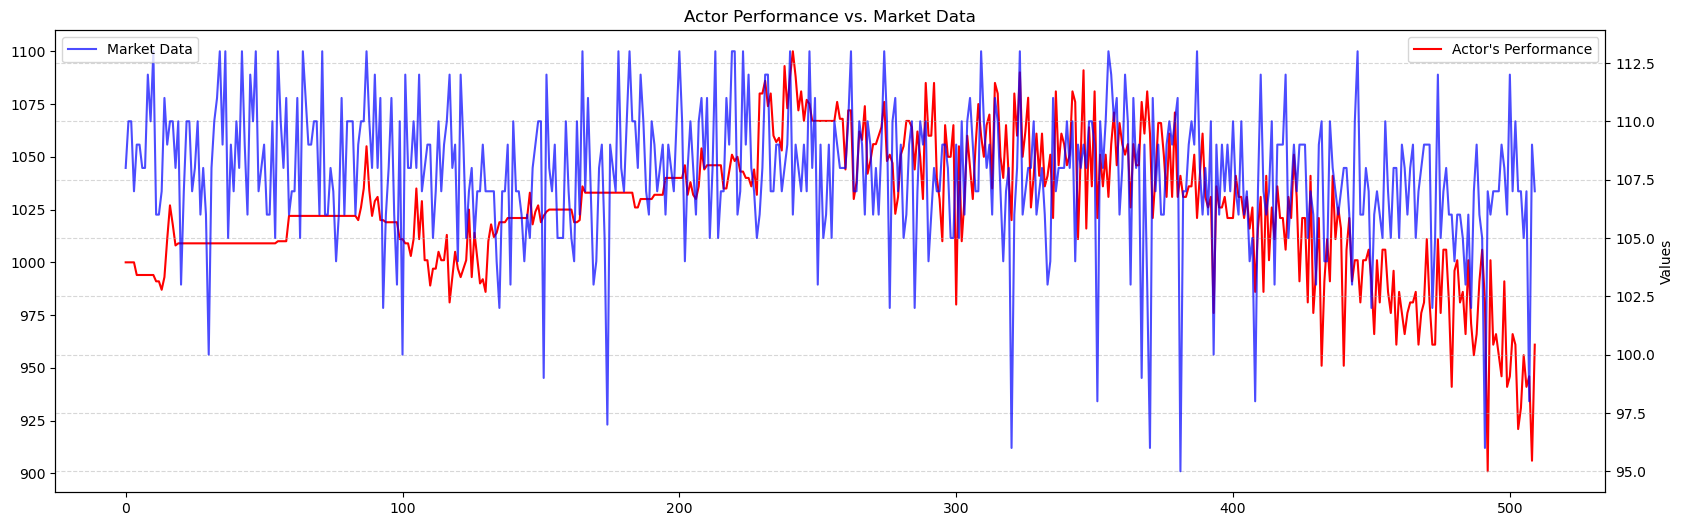

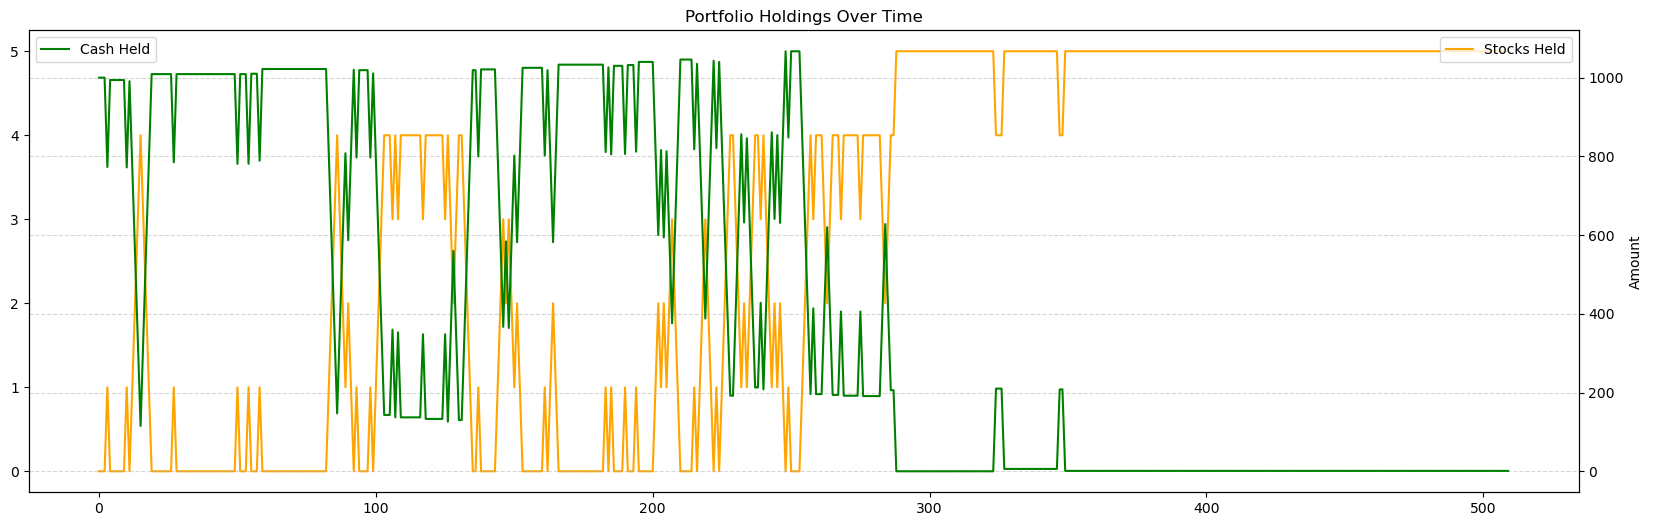

[216.41346707   0.78507509  -0.66900819  18.8826511 ]
Test Day 1


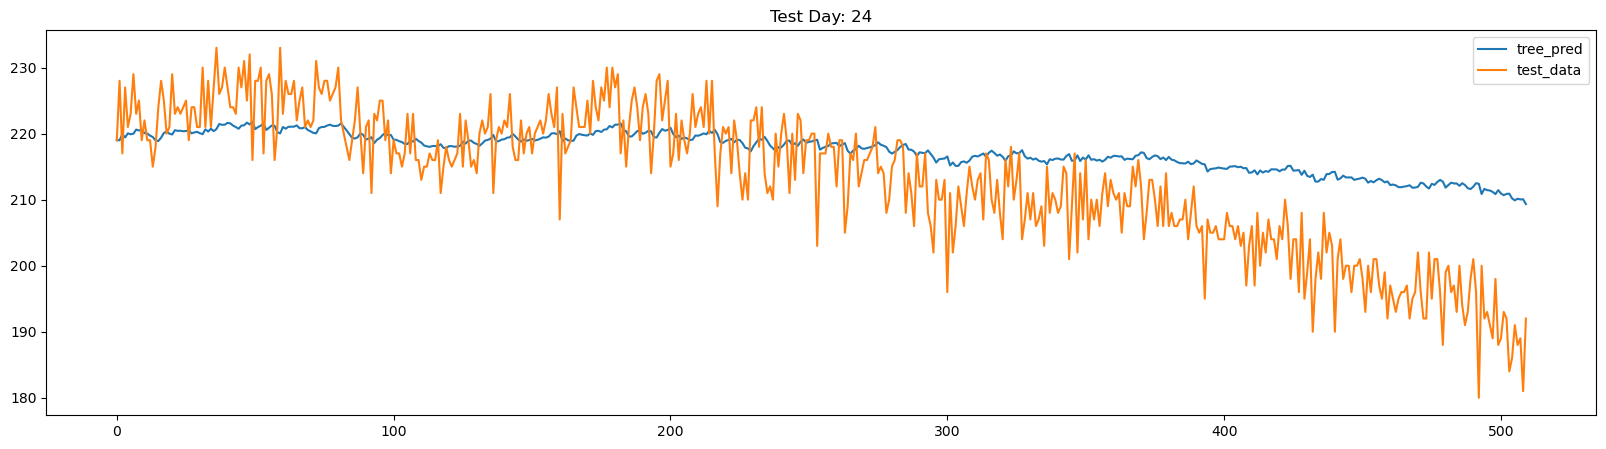

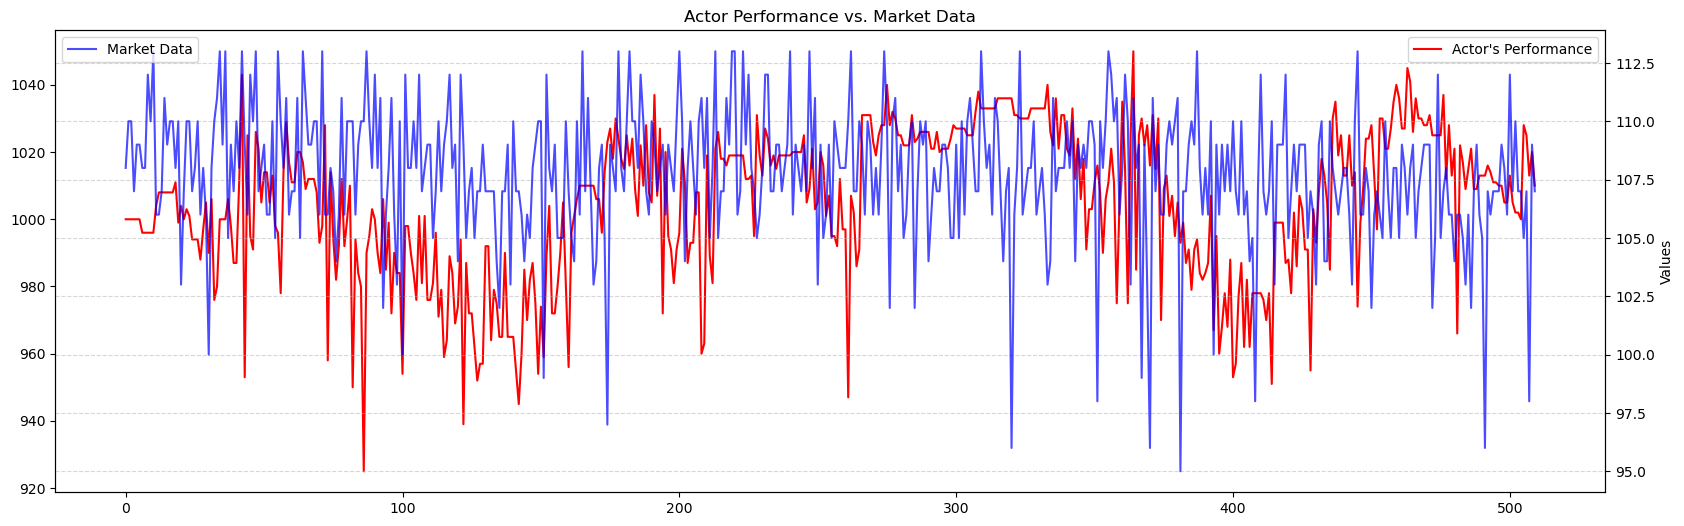

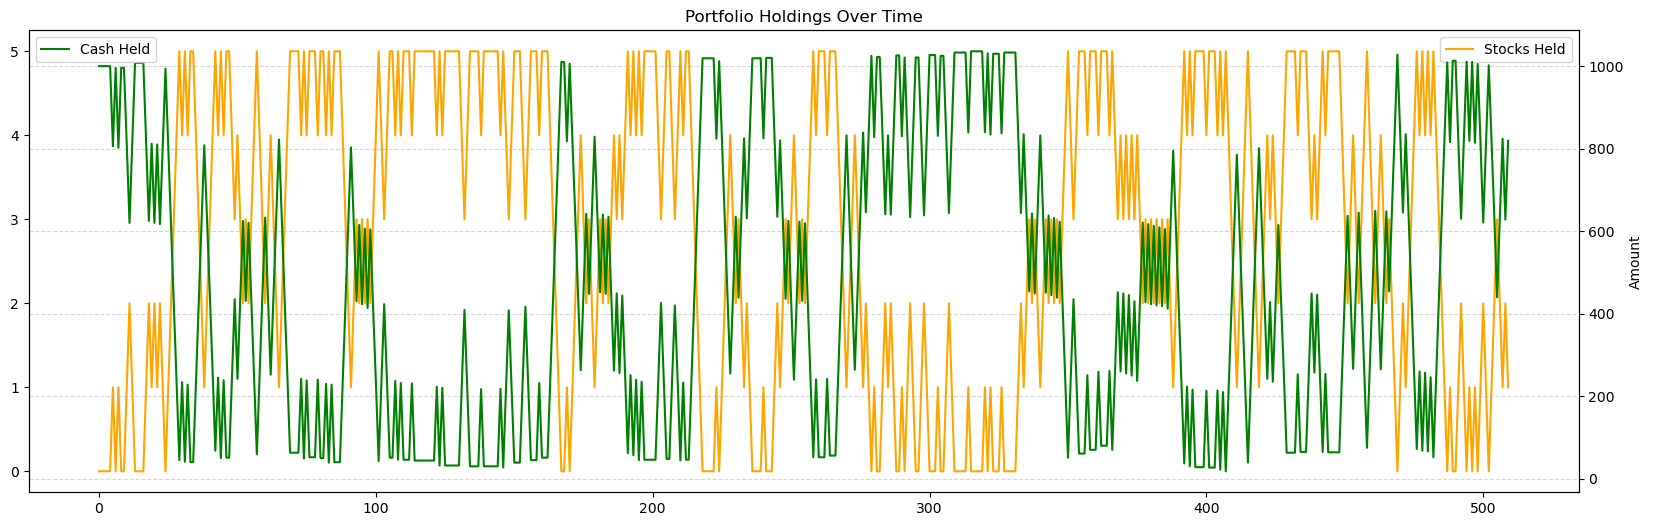

Test Day 13


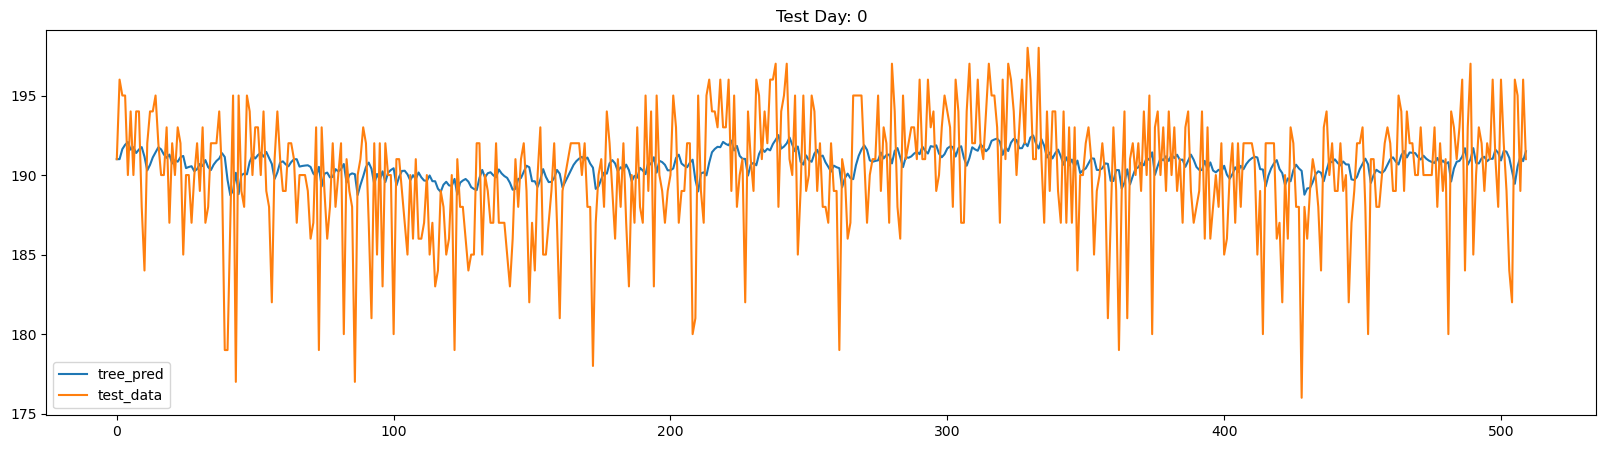

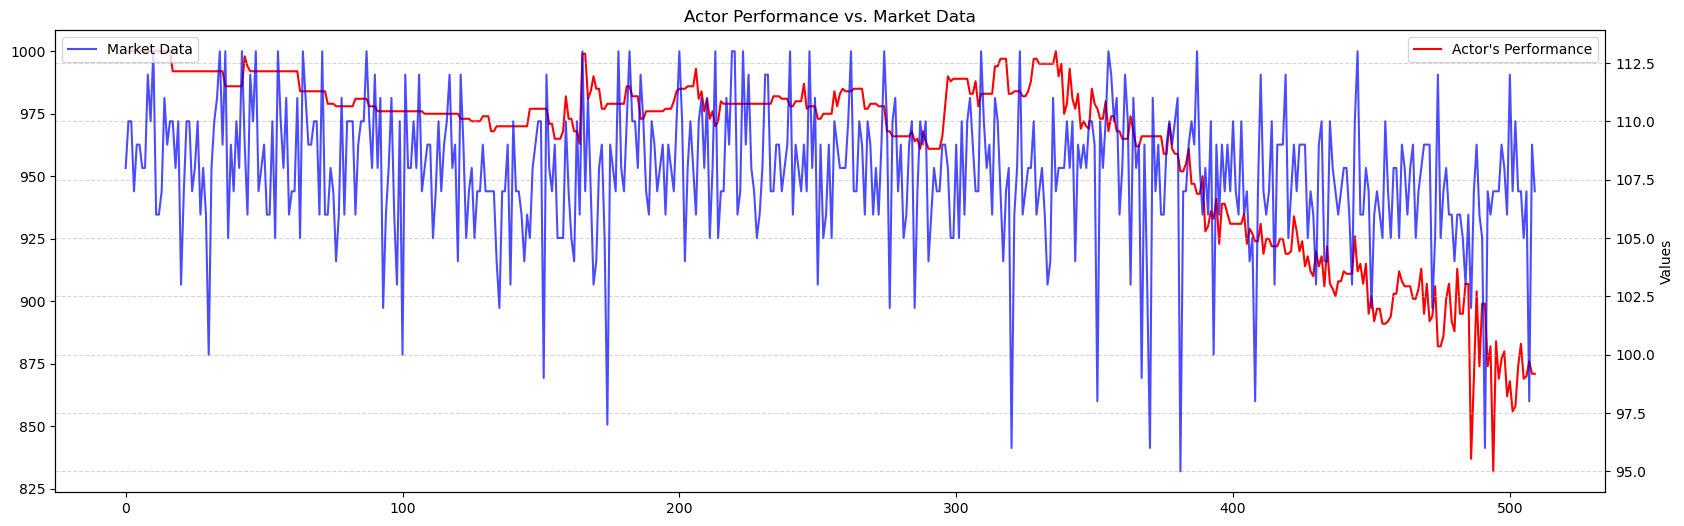

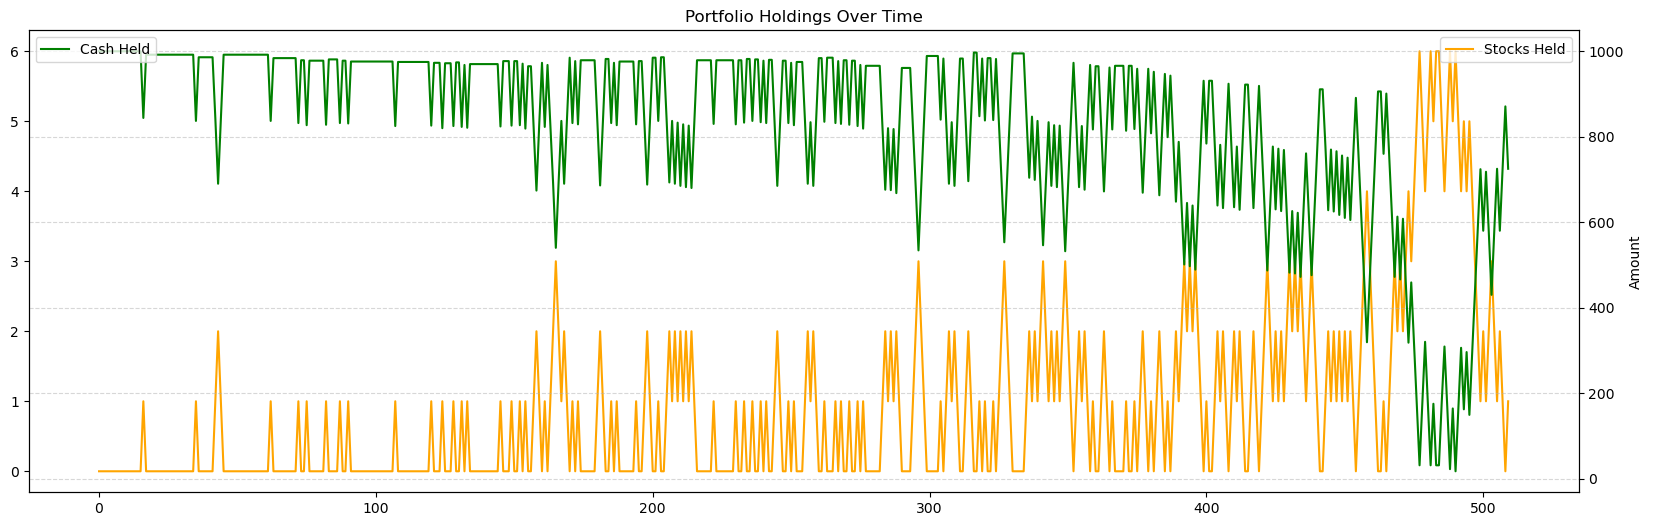

Test Day 25


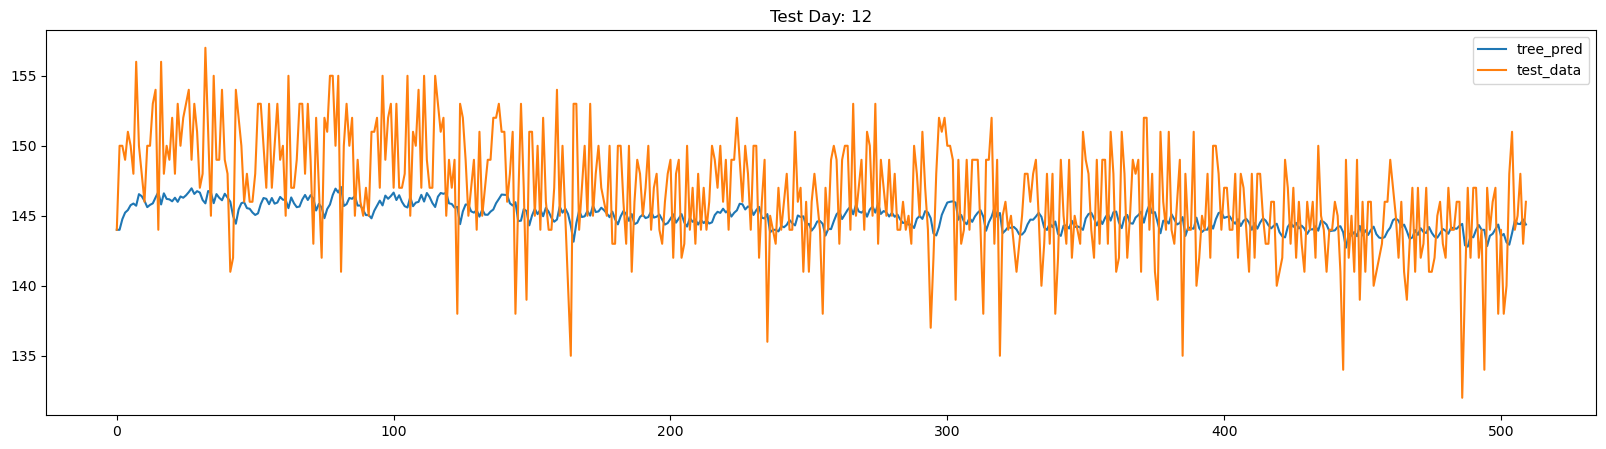

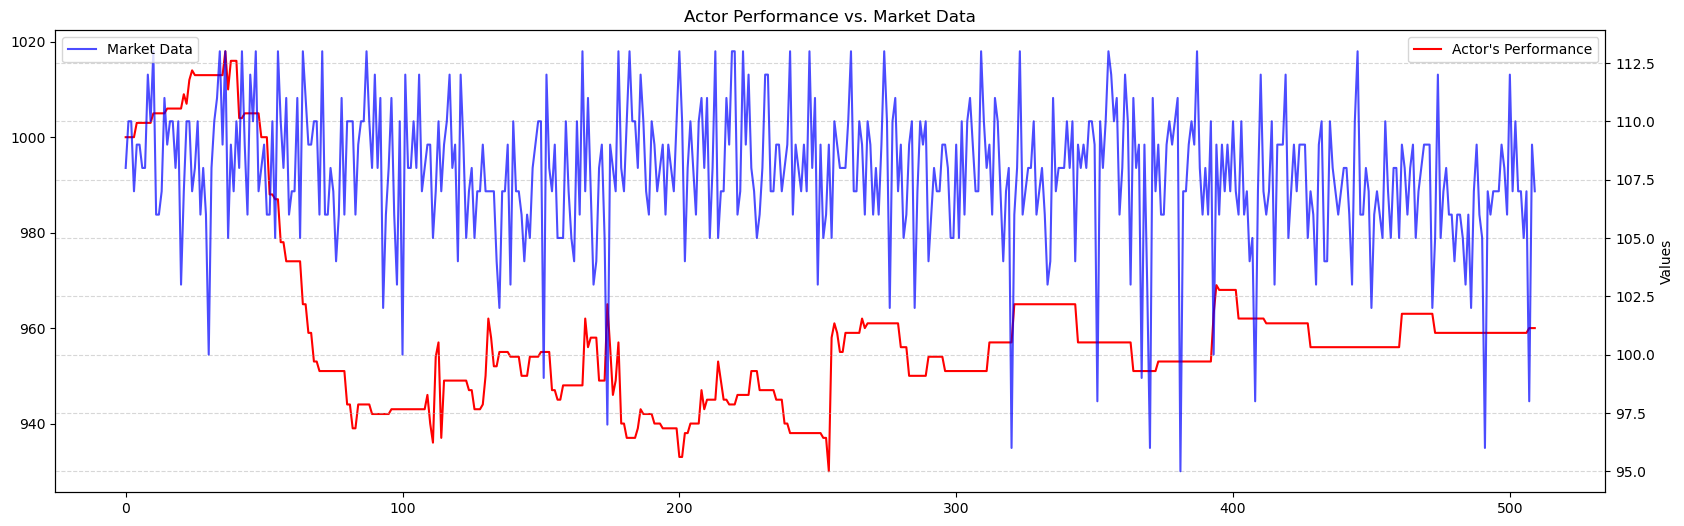

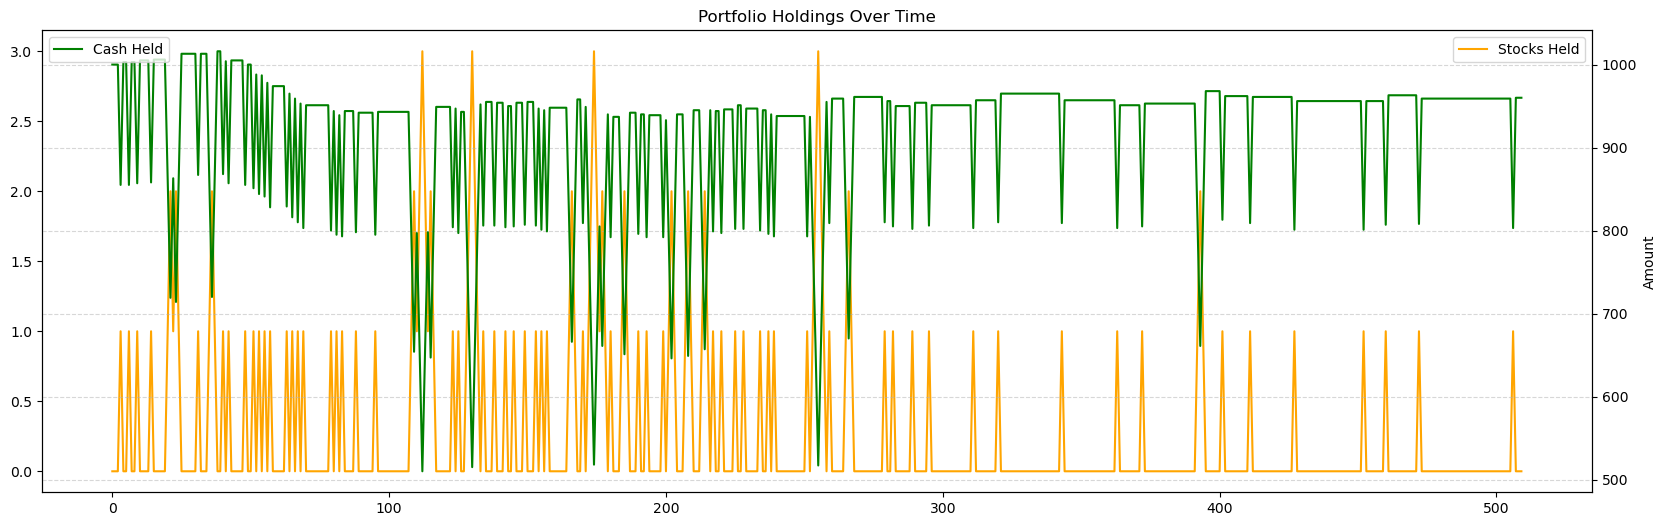

[215.64129084   0.78506831  -0.66896581  18.76687326]
Test Day 1


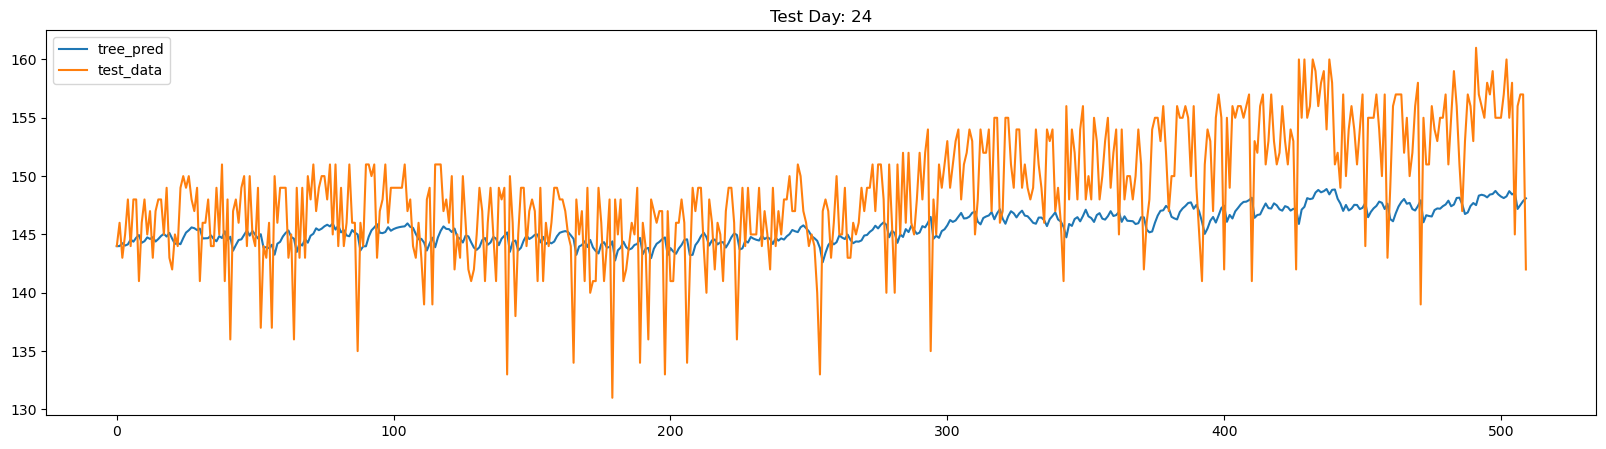

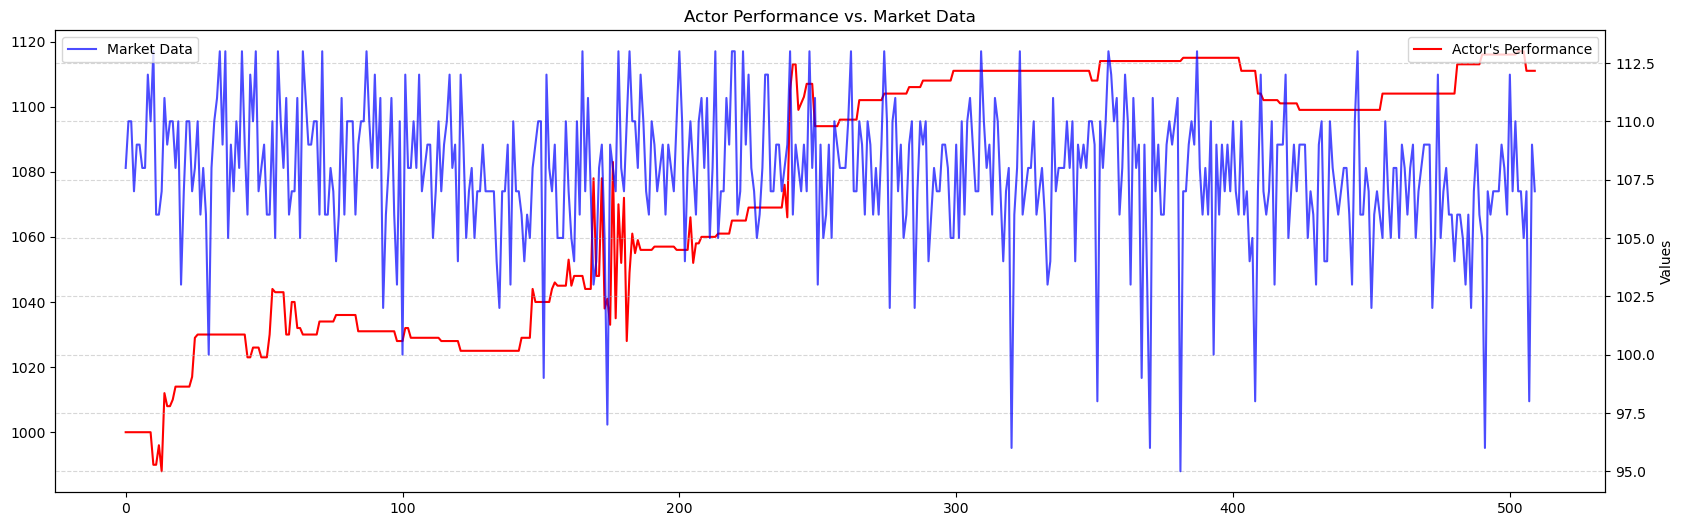

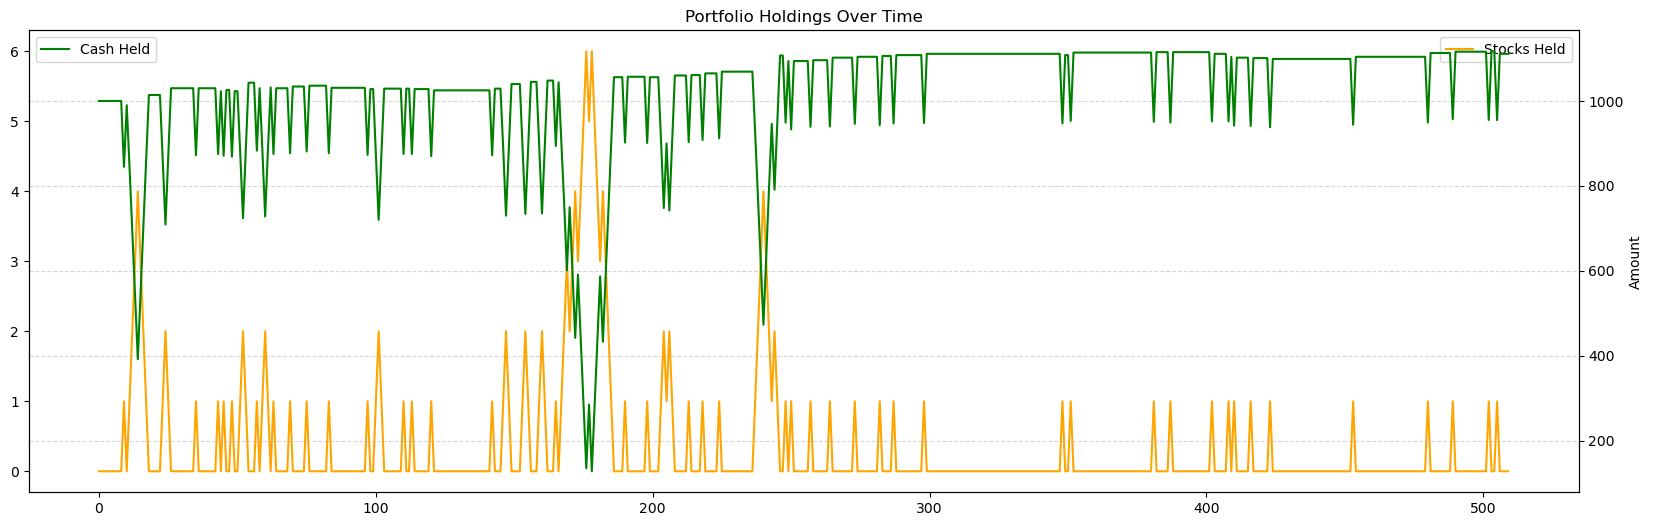

Test Day 13


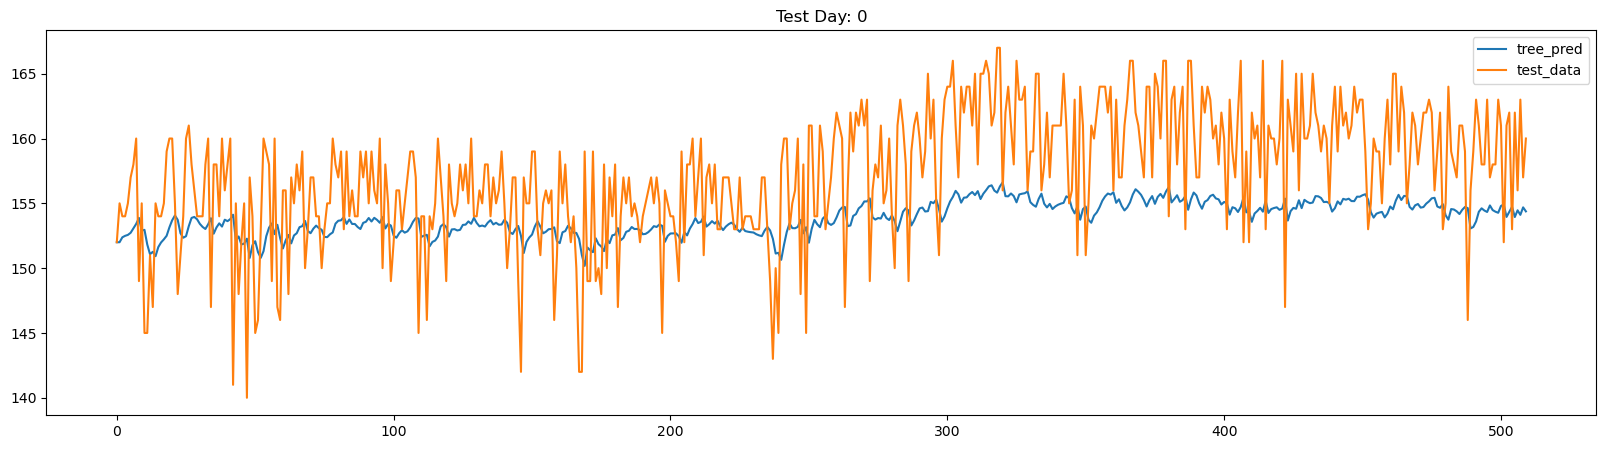

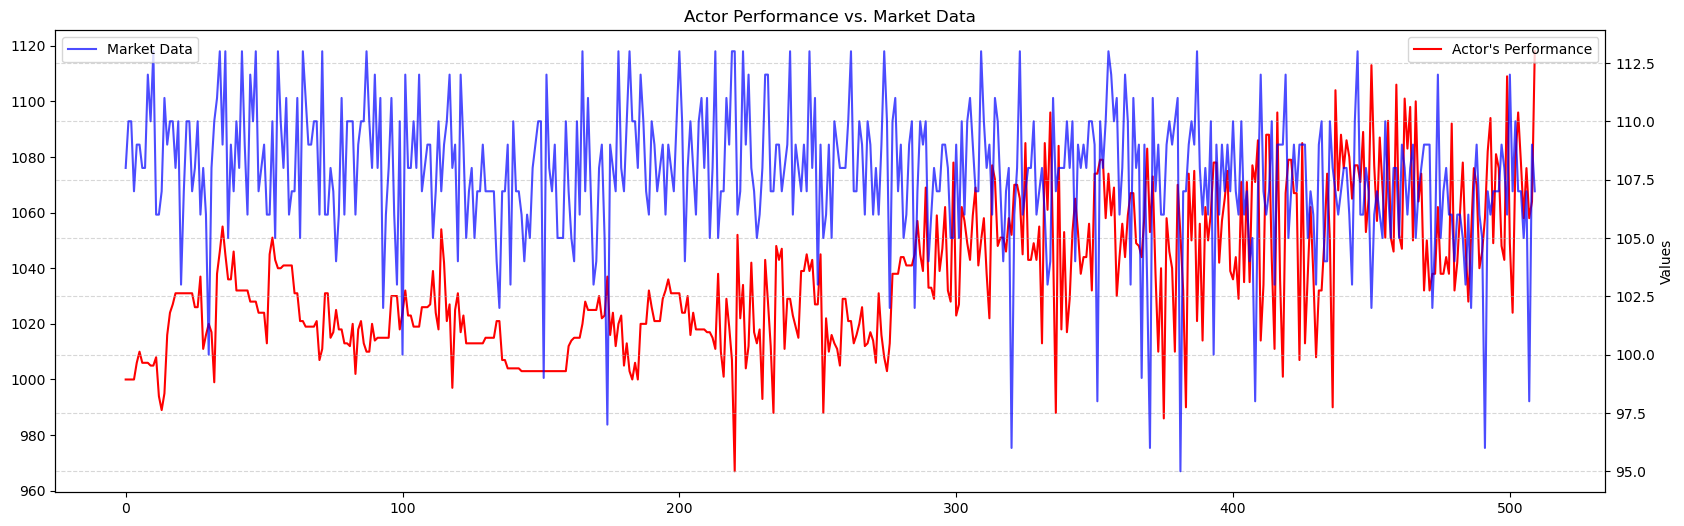

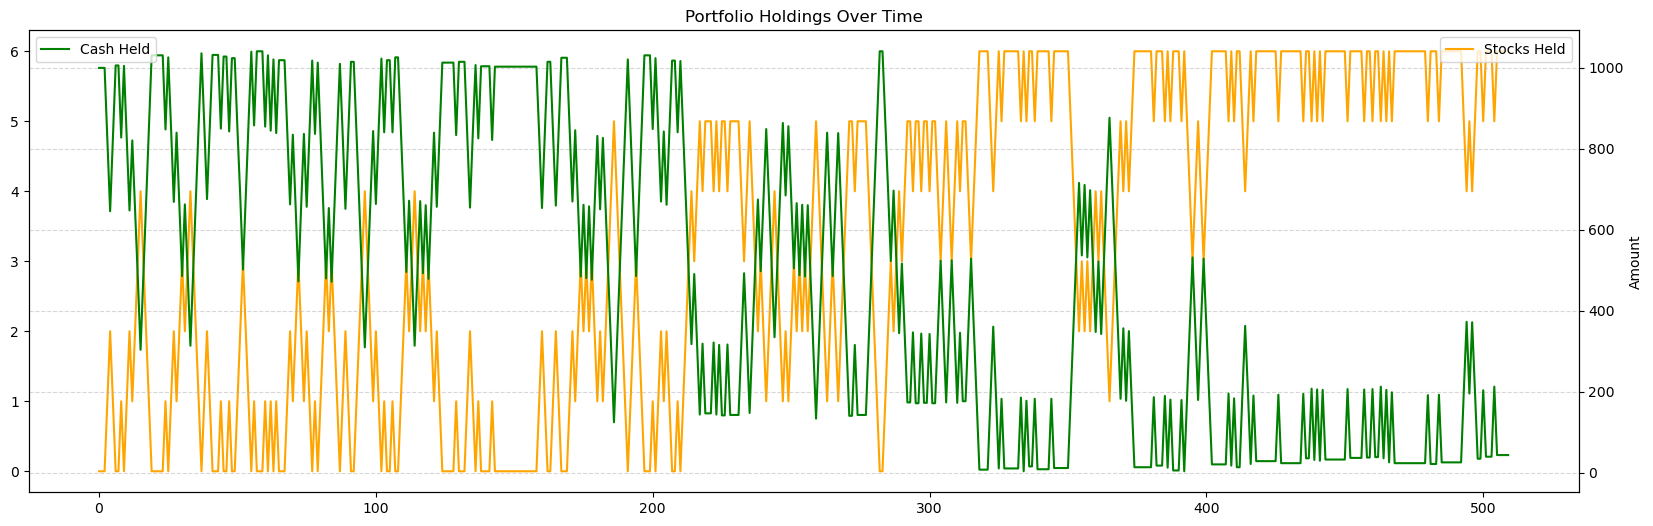

Test Day 25


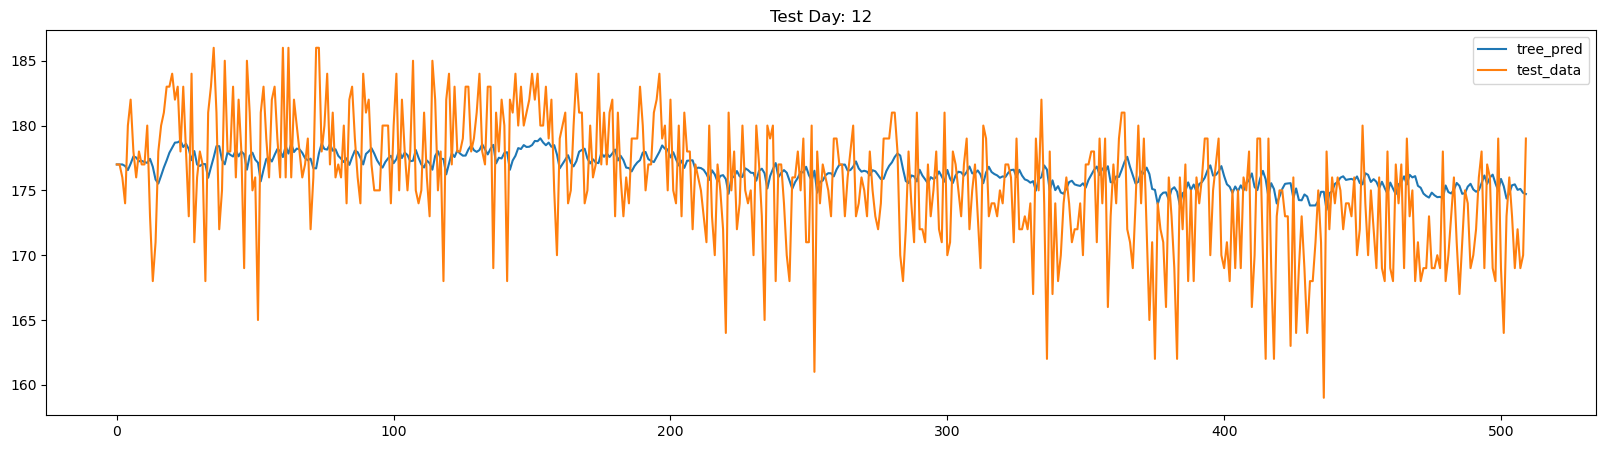

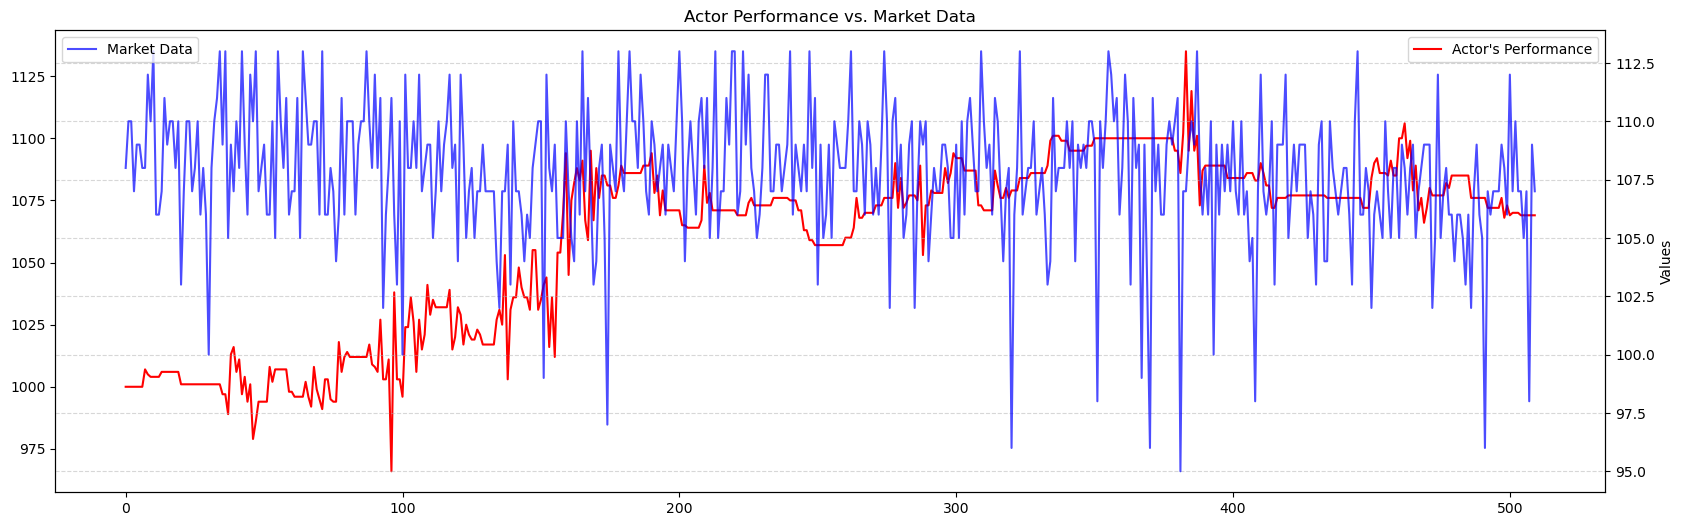

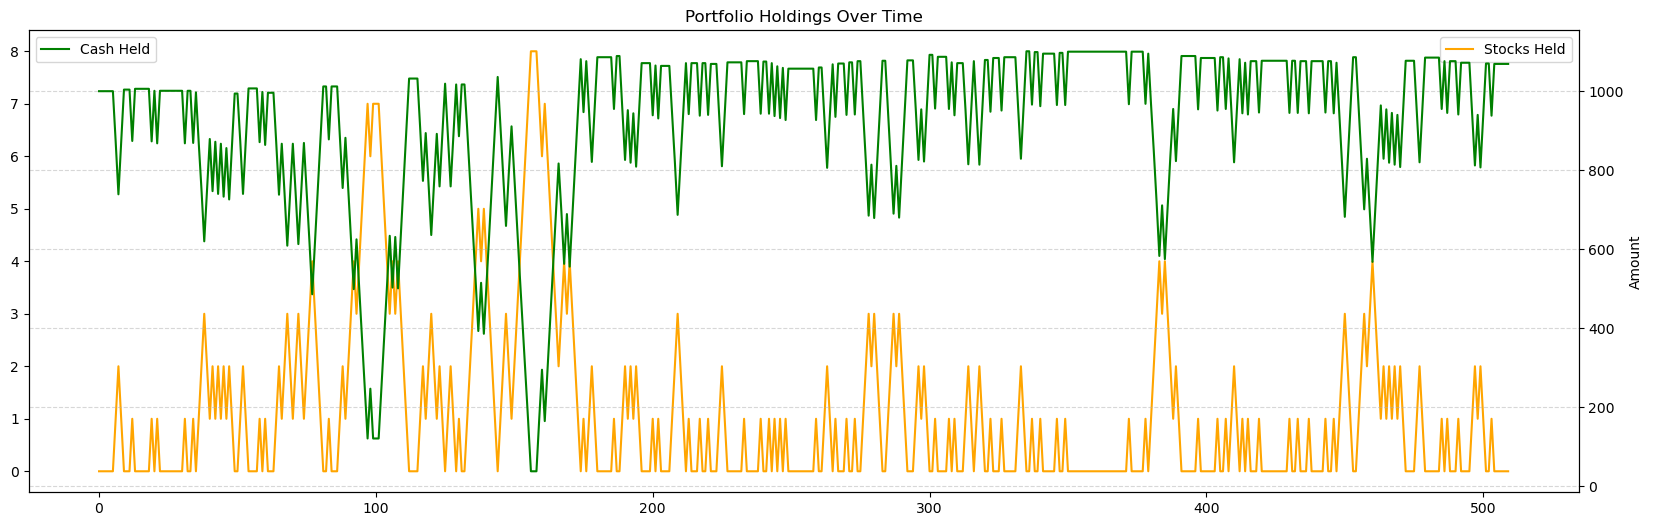

[228.40816456   0.98275401  -0.85102517  19.35926178]
Test Day 1


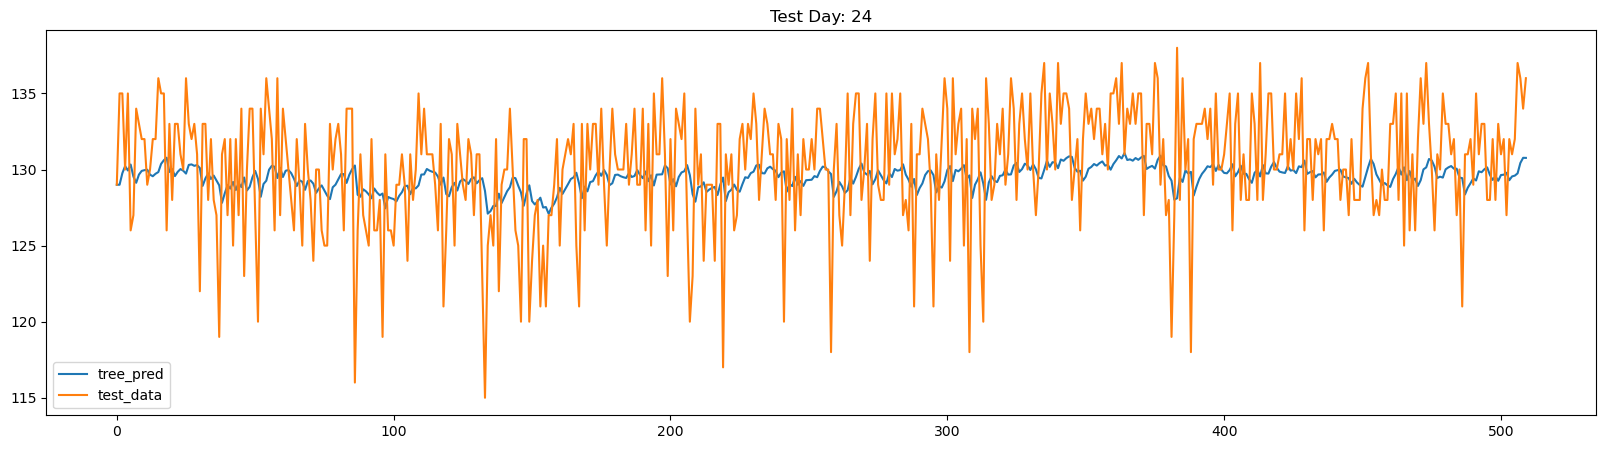

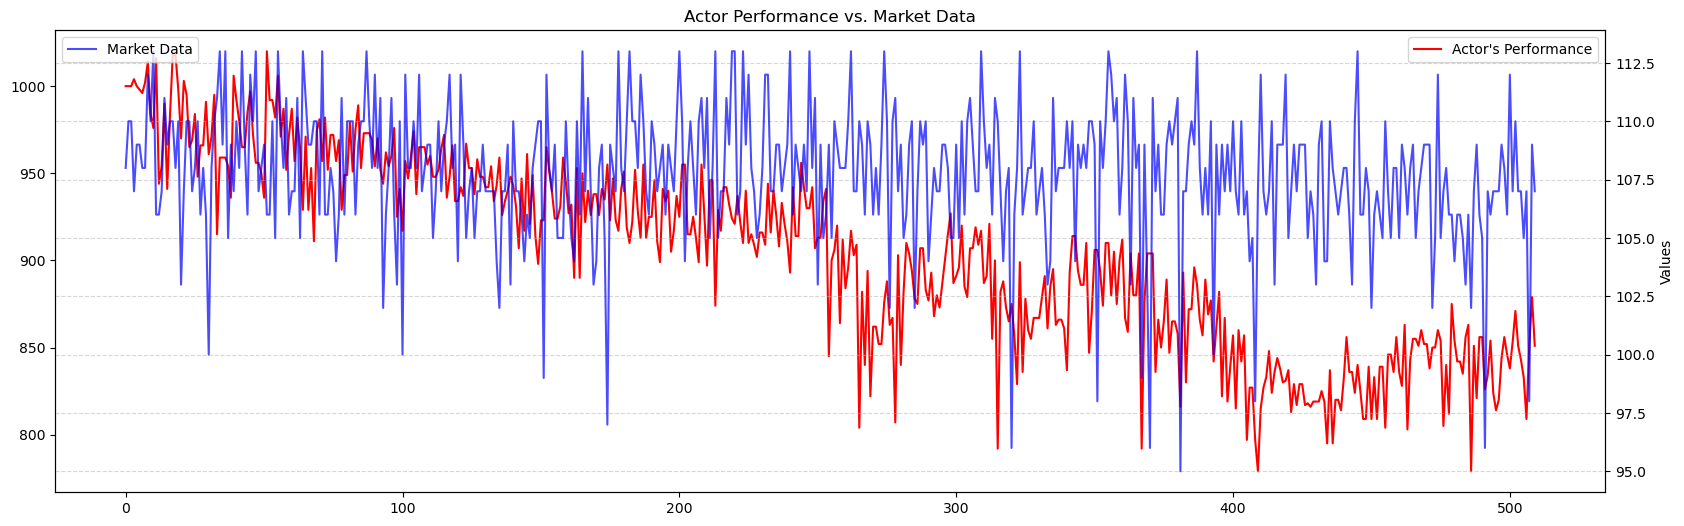

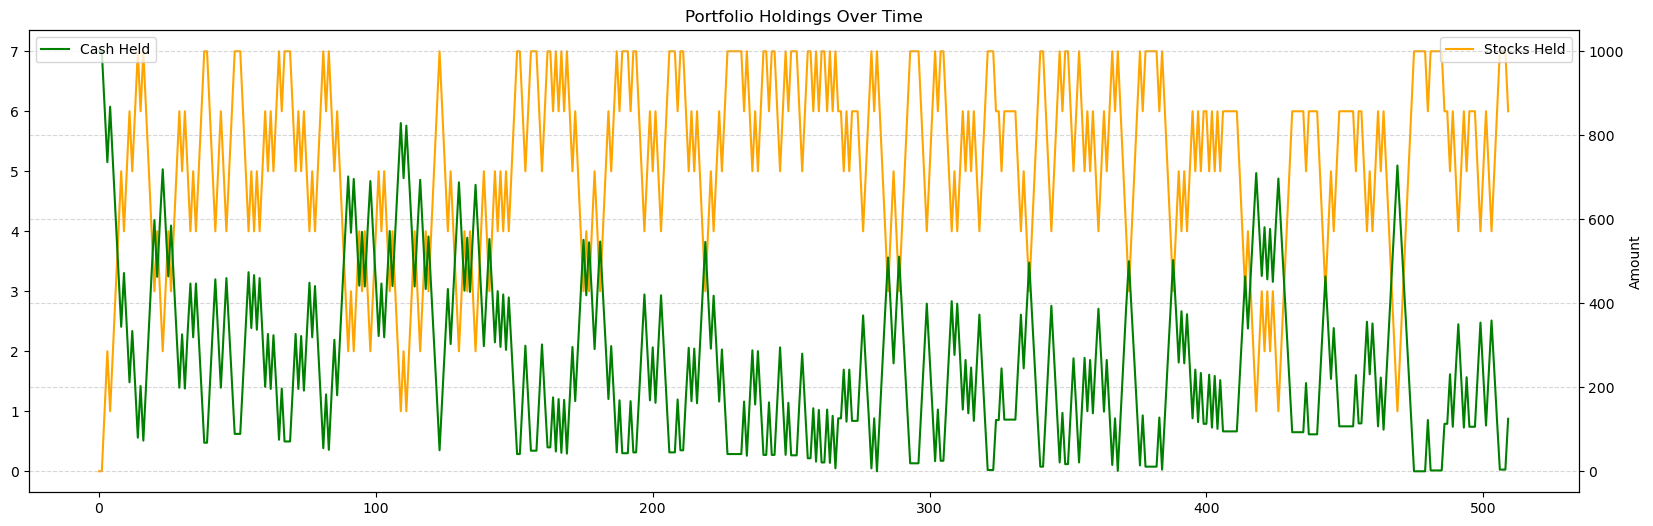

Test Day 13


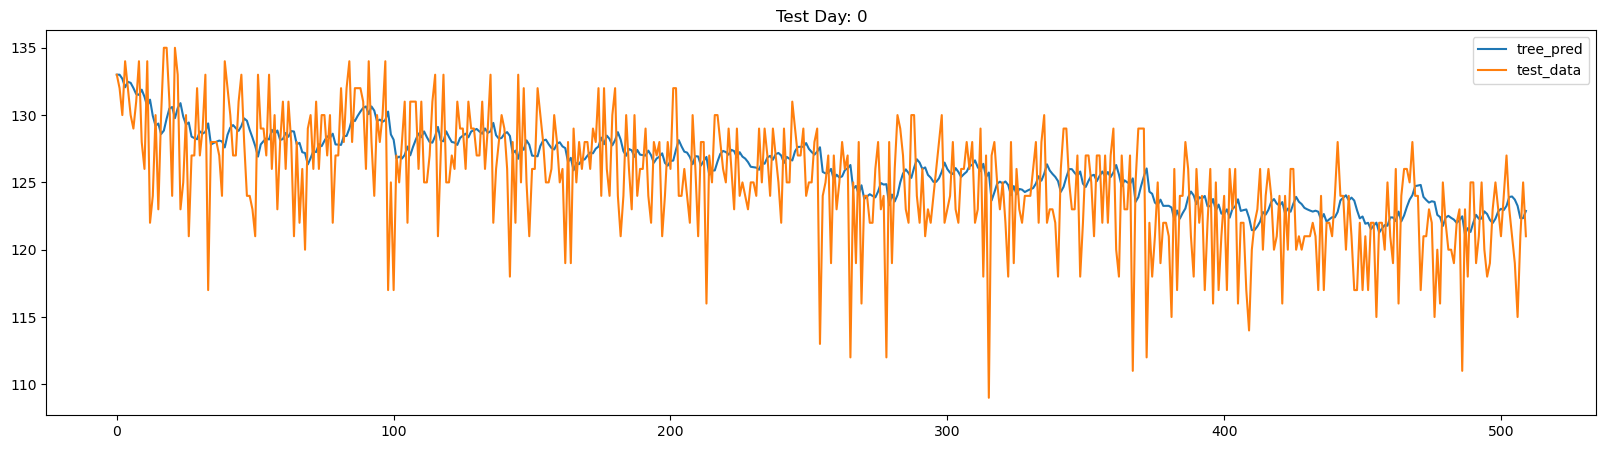

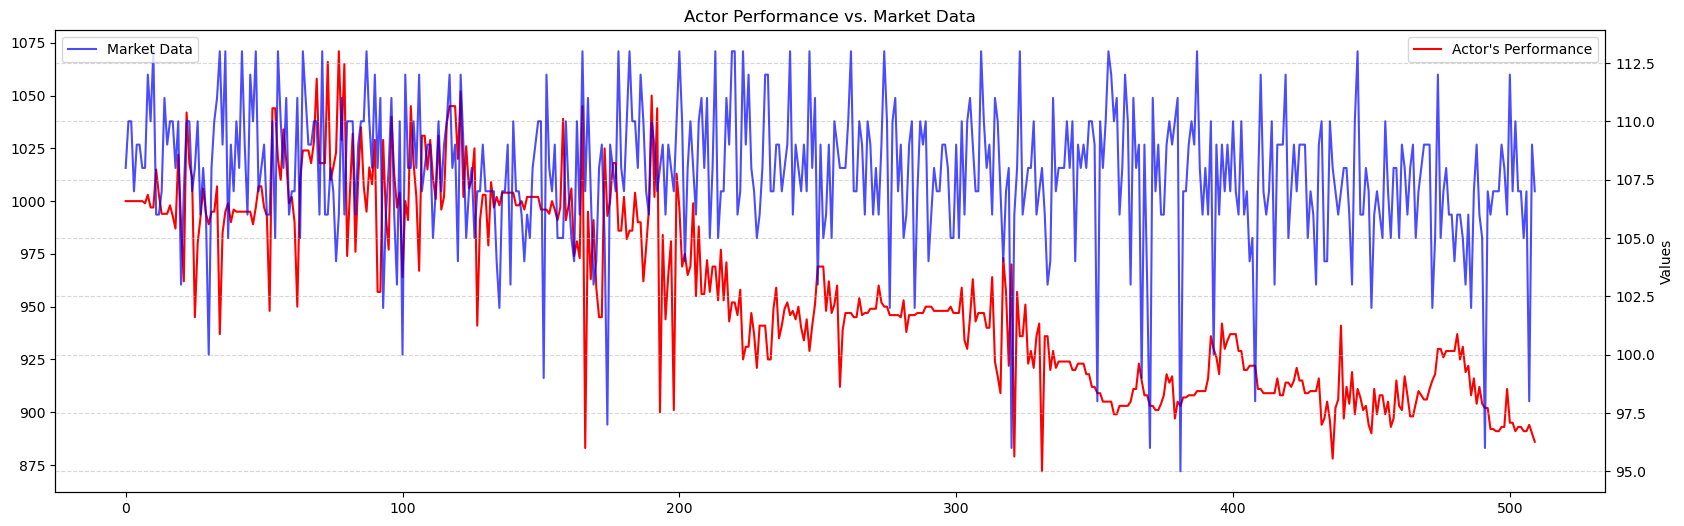

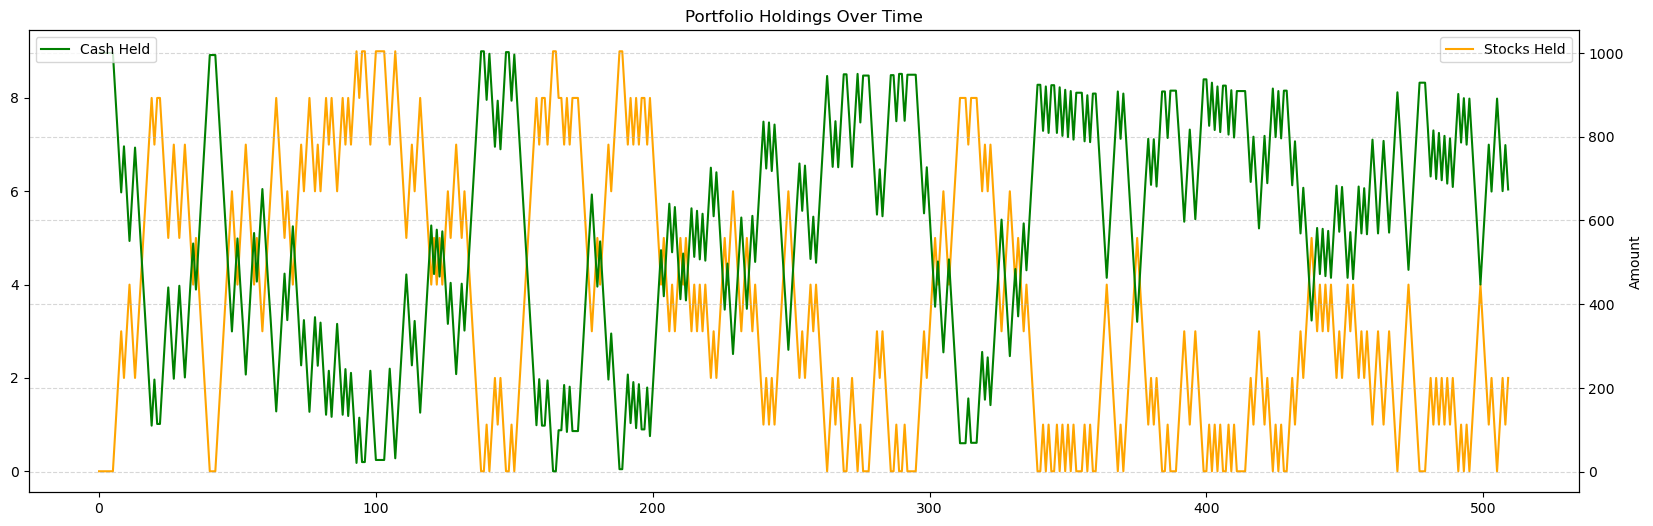

Test Day 25


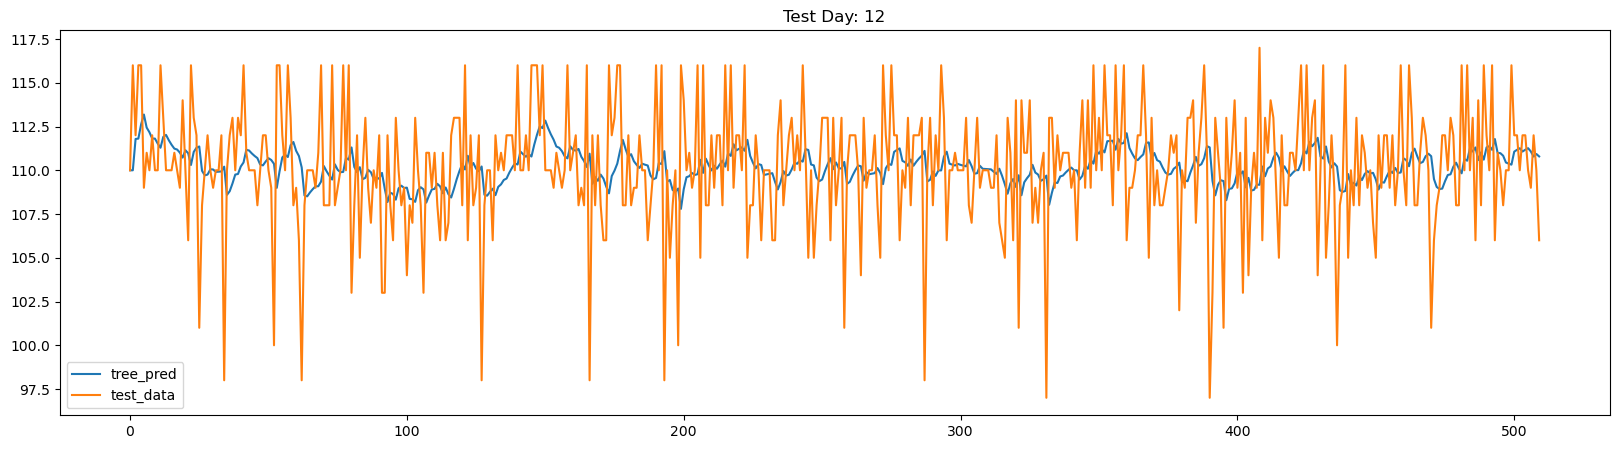

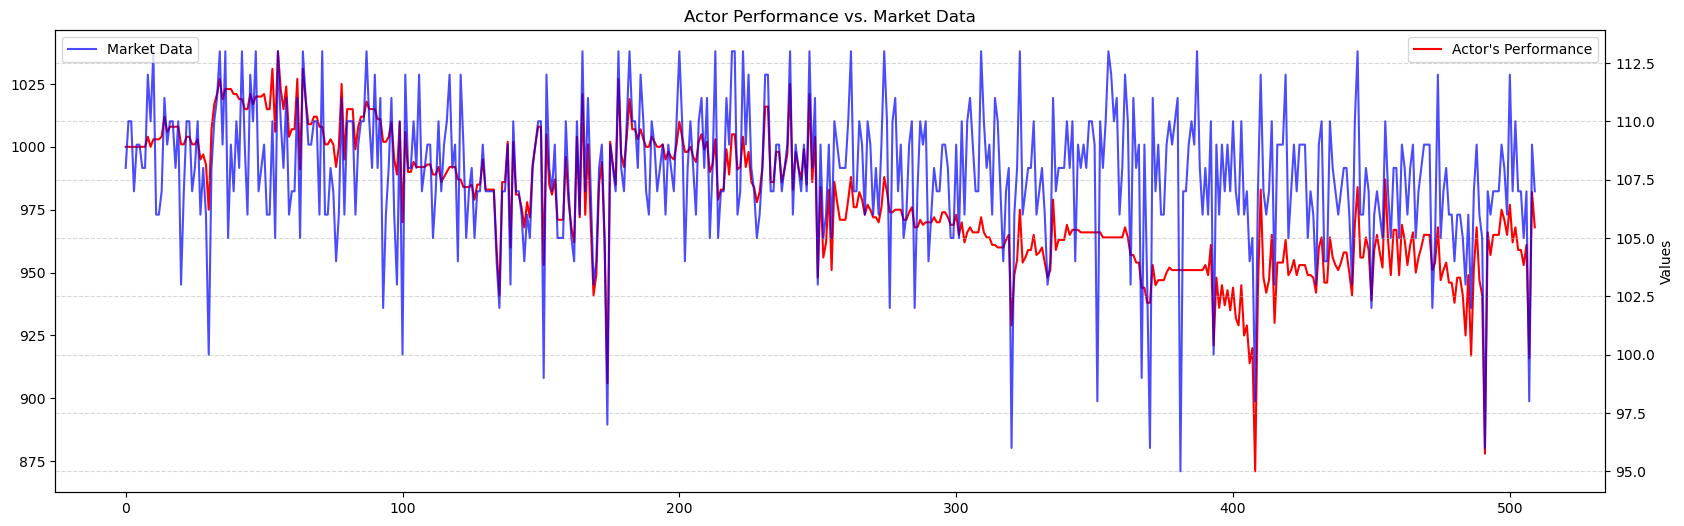

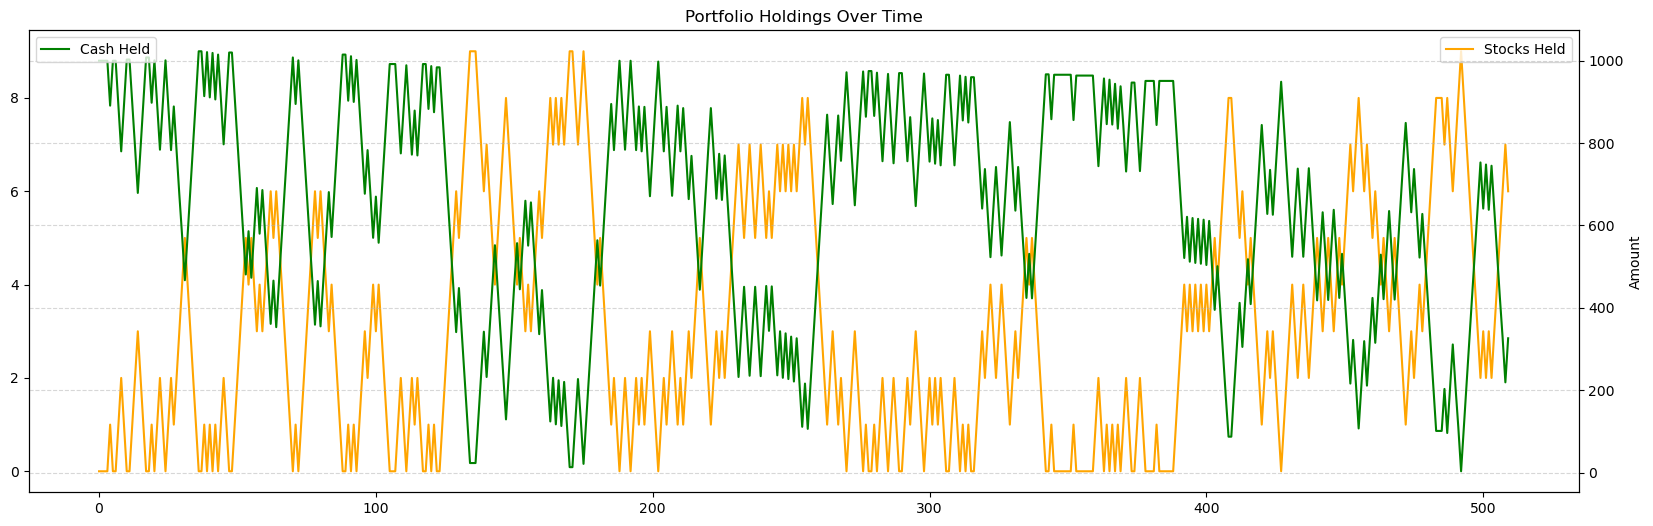

[-0.003200000000000007,
 -0.023920000000000018,
 -0.004040000000000012,
 0.007639999999999989,
 -0.011880000000000016]

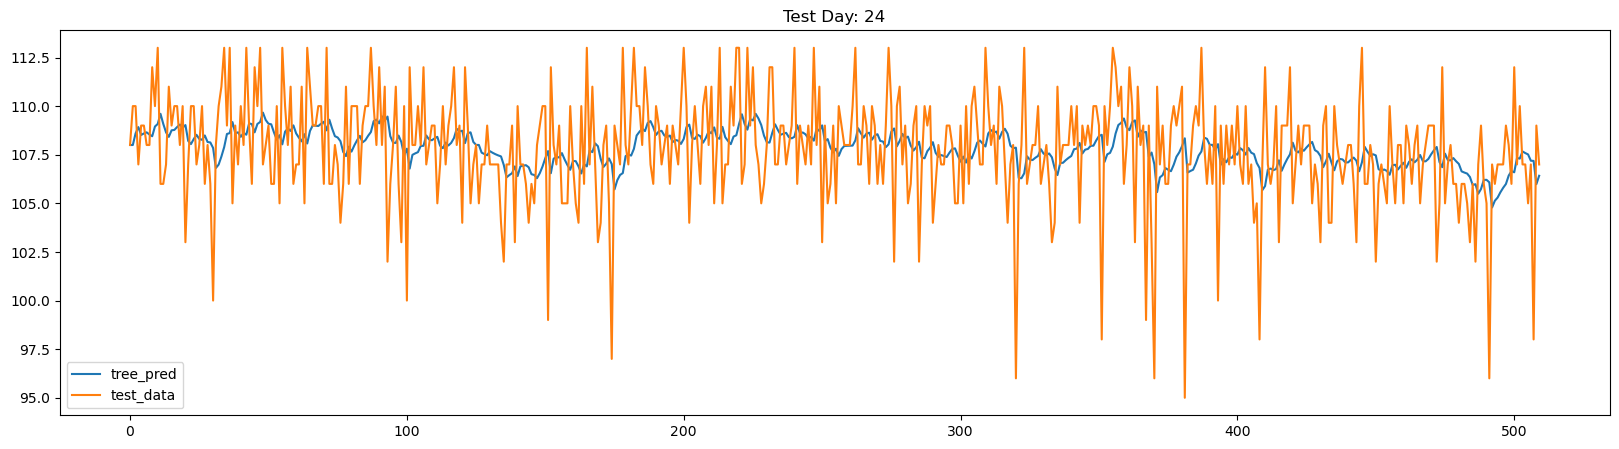

In [39]:
from statsmodels.tsa.arima.model import ARIMA
cv_scores = []
for train_data, test_data in generate_folds(tapes_data):
    # train model on training data
    coeffs = []
    for train in train_data:    
        model = ARIMA(train, order=(1, 0, 1))
        model_train_fit = model.fit()
        coeffs.append(model_train_fit.params)

    model_coeffs = np.mean(coeffs, axis=0)
    print(model_coeffs)

    def ARIMA_actor(current_data, current_cash, current_stocks):
        if len(current_data) == 0:
            return 0
        
        index = len(current_data)
        a_v = arima_predictions[index]
        eps = 0
        if current_data[-1] > a_v + eps:
            return -1
        elif current_data[-1] < a_v - eps:
            return +1
        else:
            return 0

    scores = []
    for i,test in enumerate(test_data):
        # appply model to test data
        model = ARIMA(test, order=(1, 0, 1))
        model_fit = model.fit_constrained({'const':test[0], 'ar.L1': model_coeffs[1], 'ma.L1': model_coeffs[2]})
        #print(model_fit.summary())
        fit_results = model_fit.apply(test,refit=False)
        arima_predictions = fit_results.predict()
        results = broker(ARIMA_actor, test, 1_000)
        if i % 12 == 0:
            print("Test Day", i+1)
            display_results(results, data)
            plt.figure(figsize=(20,5))
            plt.plot(arima_predictions, label ="tree_pred")
            plt.plot(test, label="test_data")  
            plt.legend()
            plt.title(f"Test Day: {i}")
        scores.append(results[-1])

    cv_scores.append(np.mean(scores))

cv_scores



[107.18833731   0.75688423  -0.68579672  12.94580718]


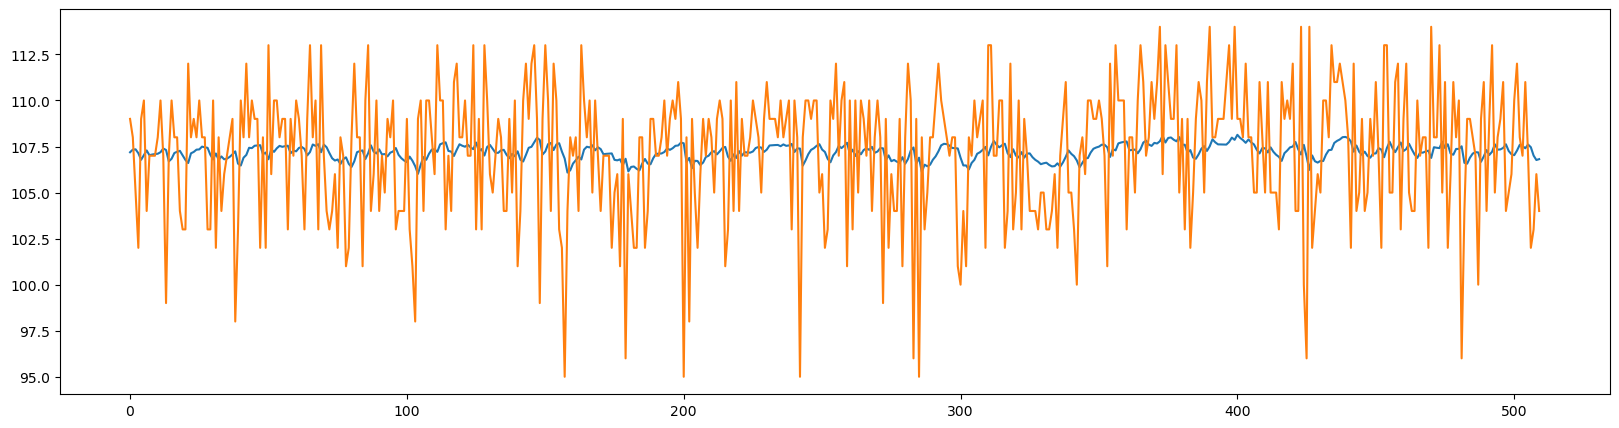

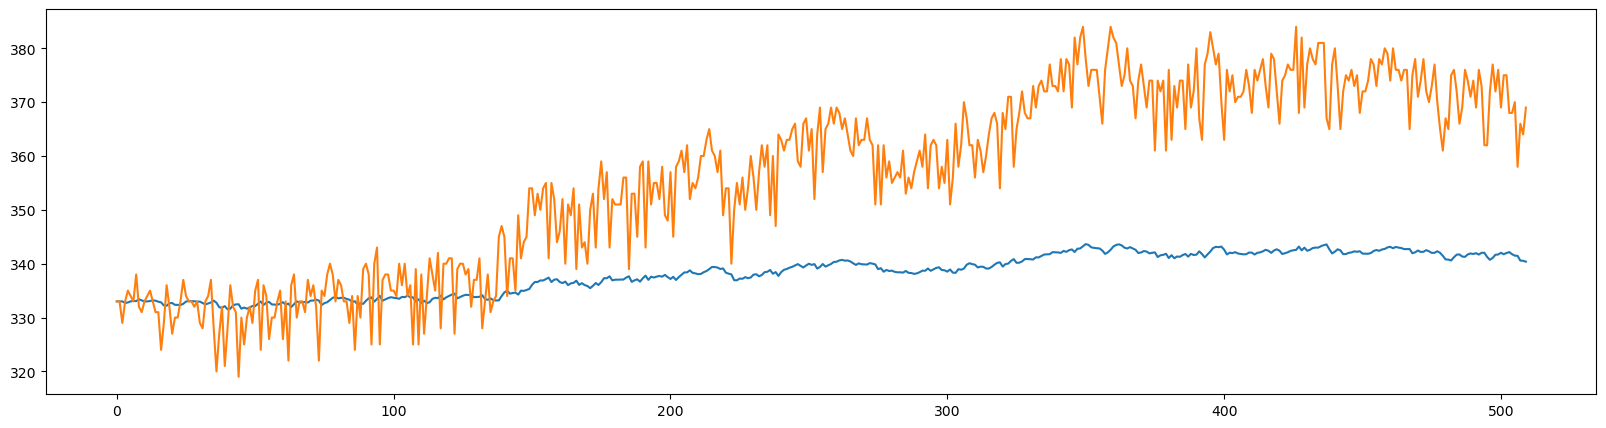

In [38]:
train_data = tapes_data[120]
test_data = tapes_data[3]
model = ARIMA(train_data, order=(1, 0, 1))
model_train_fit = model.fit()
model_train_pred = model_train_fit.predict()
model_coeffs = model_train_fit.params

print(model_coeffs)
model = ARIMA(test_data, order=(1, 0, 1))
model_fit = model.fit_constrained({'const':test_data[0], 'ar.L1': model_coeffs[1], 'ma.L1': model_coeffs[2]})
fit_results = model_fit.apply(test_data,refit=False)
arima_predictions = fit_results.predict()

plt.figure(figsize=(20,5))
plt.plot(model_train_pred, label ="train_pred")
plt.plot(train_data, label="train_data")



plt.figure(figsize=(20,5))
plt.plot(arima_predictions, label ="tree_pred")
plt.plot(test_data, label="test_data")